**Identifying overperforming schools**

by Ben Lacar
<br>
Updated August 2019

As an exercise in performing wrangling, data exploration, and data visualization, I chose to look at publicly available datasets of California public schools and census information. While exploring, I sought to identify overperforming school populations. I define this as a school's population that faces socio-economic difficulties yet have low dropout rates.

After talking with Morgan, plan is to start small and simple, then add complexity.



The data sources are at the level of granularity of zip code.

Similar applications of demographics towards predicting health outcomes has been performed by [Luo et al., 2015](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0125602). The Luo et al. study helped serve as a reference for analyses done here.

Project updates:

- August 2017: Performed data munging and visualizations as an exercise following Python courses.

- March 2018: First posting to website.

- April 2018: Received project feedback and began re-writing code to improve readability and code robustness.

- May 2018: Expanded project to include more demographic features other than just local median income and percentage of families below the poverty line. Develop a greater understanding of features by applying linear regression.

- June 2018: Continued improvements to code robustness.

- September 2019:

Used GreatSchools data. Find features that predict good low income ratings.




In [4]:
# Import packages

# Web scraping
import os
import urllib.request
import requests
from io import StringIO
from bs4 import BeautifulSoup
# Use xml package for GreatSchools data
import xml.etree.ElementTree as ET

# Dataframe munging and statistics
import re
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.decomposition import PCA

# Machine learning, linear regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [5]:
parent_path = '/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/'
os.chdir(parent_path) 
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

## Census info and school enrollment data sources
1. Demographic information for CA by zip code (median income, employment status, worker class, education level)
2. School information (public, charter status, magnet status, address)
3. School enrollment and dropout data (by grades for ethnicity, gender)

### Data source 1: Population data by zip code (factfinder.census.gov)

#### Import and overview of census data

In [6]:
df_demo_info = pd.read_csv('data/ACS_15_5YR_DP03_with_ann.csv')
df_demo_info.head()

,Id,Id2,Geography,Estimate; EMPLOYMENT STATUS - Population 16 years and over,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Percent; EMPLOYMENT STATUS - Population 16 years and over,Percent Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force,...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over
0,8600000US89010,89010,ZCTA5 89010,484,125,484,(X),233,92,48.1,...,19.7,17.5,(X),(X),21.2,16.2,(X),(X),39.1,23.2
1,8600000US89019,89019,ZCTA5 89019,1663,527,1663,(X),852,310,51.2,...,10.1,15,(X),(X),0,2.2,(X),(X),24.9,16.8
2,8600000US89046,89046,ZCTA5 89046,404,136,404,(X),175,96,43.3,...,10.9,13.4,(X),(X),41,34,(X),(X),40.1,20.6
3,8600000US89060,89060,ZCTA5 89060,8136,629,8136,(X),3473,514,42.7,...,10.7,5.1,(X),(X),18.5,6.9,(X),(X),23.9,6.2
4,8600000US89061,89061,ZCTA5 89061,4492,529,4492,(X),1889,340,42.1,...,2.5,3,(X),(X),3.2,3,(X),(X),18.2,11.8


In [7]:
for i in df_demo_info['Id2'].unique():
    df_temp = df_demo_info[df_demo_info['Id2']==i]
    if df_temp.shape[0] > 1:
        df_temp
        break

In [8]:
df_demo_info['Id2'].unique()

array([89010, 89019, 89046, ..., 96155, 96161, 97635])

In [9]:
def import_census_data(csv_file):
    df_demo_info = pd.read_csv('data/ACS_15_5YR_DP03_with_ann.csv')
    df_demo_info.set_index('Id2', inplace=True) # set the zip code as the index value
    
    # Rename demographic information columns to improve readability
    demo_column_names = ({'Estimate': 'Est.',
                      'Percent': '%',
                      'EMPLOYMENT STATUS': 'EMPLOY_STATUS',
                      'Population': 'Pop.',
                      'Margin of Error': 'error_margin',
                      'and over': 'and up',
                      'years':'yrs',
                      'COMMUTING TO WORK': 'WORK_COMMUTE',
                      'CLASS OF WORKER': 'WORKER_CLASS',
                      'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)': 'INCOME_BENEFITS',
                      'HEALTH INSURANCE COVERAGE': 'HEALTH_INS_COVERAGE',
                      '(dollars)': '($)',
                      'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL': '%-AGE_FAMILIES_INCOME_BELOW_POVERTY',
                      '18 to 64': '18-64',
                      'with': 'w/',
                      'With': 'w/',
                      'under 18': '<18',
                      'population': 'pop.',
                      'health insurance coverage': 'health ins coverage'
                     })

    # Replace words in column names
    df_temp = pd.DataFrame()
    df_temp['old_col_names'] = df_demo_info.columns
    df_temp['new_col_names'] = None
    
    for i in range(len(df_temp)):
        string = df_temp.loc[i,'old_col_names']
        for key in demo_column_names:
            string = string.replace(key, demo_column_names[key])
        df_temp.loc[i, 'new_col_names'] = string
    df_demo_info.columns = df_temp['new_col_names']

    # Remove columns that contain "error" since it won't be used in the analysis moving forward.
    mask_col_w_error = df_demo_info.columns.str.contains('error')
    df_demo_info = df_demo_info.copy().loc[:,~mask_col_w_error]

    # Remove columns where most values are (X) 
    mask_of_X = df_demo_info.iloc[:,274]!='(X)'

    mask_of_X = df_demo_info !='(X)'
    samples_w_values = np.sum(mask_of_X)
    mask_columns_samples_wvalues = np.sum(mask_of_X) > 1400

    # Demographic info with values, no errors
    df_demo_info = df_demo_info.copy().loc[:,mask_columns_samples_wvalues]
    
    # Focus on features shown in percentages (other code were things I tried)
    mask_perc = df_demo_info.columns.str.startswith('%')
    #mask_est = df_test.columns.str.startswith('Est.')
    # df_test_only_numbers = df_test.loc[:, (mask_perc + mask_est)].copy()

    # Convert all strings with a dash into NaN
    df_demo_perc_only = df_demo_info.loc[:, mask_perc].copy()

    # Convert all strings with a dash into NaN
    mask_dash = (df_demo_perc_only=='-')  
    mask_x = (df_demo_perc_only=='(X)') 
    df_demo_perc_only[mask_dash | mask_x] = np.nan

    # Convert rest of values from string to floating point
    df_demo_perc_only = df_demo_perc_only.astype('float64', copy=False)
    
    # Identify features where most (90%) of the values are < 100%
    df_temp = pd.DataFrame()
    df_temp['feature'] = None
    df_temp['min'] = None
    df_temp['max'] = None
    df_temp['prop_<100%'] = None

    # Check range of values and determine the proportion less than 100%
    for index, value in enumerate(df_demo_perc_only.columns):
        try:
            df_temp.loc[index, 'feature'] = value
            df_temp.loc[index, ['min', 'max']] = (df_demo_perc_only[value].min(), df_demo_perc_only[value].max())
            # For next line, NaNs are not counted
            df_temp.loc[index, 'prop_<100%'] = sum(df_demo_perc_only[value] <= 100)/len(df_demo_perc_only)
        except:
            continue

    # Get features where most (90%) of the values are < 1 (100%)
    valid_features = df_temp.loc[df_temp['prop_<100%'] >= 0.9, 'feature'].tolist()
    
    # Add the identifying columns back in and include those about income
    income_columns = df_demo_info.columns[df_demo_info.columns.str.contains('income')].tolist()
    
    df_demo_info_perc = pd.merge(df_demo_info[['Id', 'Geography'] + income_columns], df_demo_perc_only[valid_features],
                                  left_index=True, right_index=True)
    
    # Remove rows where 90% of the census info for that zip code is missing
    df_demo_info_final = df_demo_info_perc[df_demo_info_perc.count(axis=1)/df_demo_info_perc.shape[1] >= 0.9]
    
    return df_demo_info_final

In [10]:
df_census = import_census_data('ACS_15_5YR_DP03_with_ann.csv')

### Data Source 2: School information (public, charter status, magnet status, address) 

- Import the school info and extract the 5 digit code for each school district

In [11]:
def import_school_info():
    # url = 'ftp://ftp.cde.ca.gov/demo/schlname/pubschls.xls'  # old url
    url = 'https://www.cde.ca.gov/SchoolDirectory/report?rid=dl1&tp=xlsx&ict=Y'  # new url
    socket = urllib.request.urlopen(url)
    df = pd.read_excel(socket, skiprows=5)
    
    # Remove last row which has string and Nas (total records row)
    df = df.iloc[:-1]
    # Change CDSCode column from string to integer for later merging
    df['CDSCode'] = df['CDSCode'].astype('int')
    
    # Have the zip code format match the census format for later merging
    df['zip_code'] = df['Zip'].str.split('-', expand=True).iloc[:,0]
    # Deal with missing data and change type to int64 so it can be merged
    df['zip_code'] = df['zip_code'].replace('No Data', 0).fillna(0).astype(np.int64)
    
    return df

In [12]:
df_school_info = import_school_info()

In [13]:
df_school_info.columns

Index(['CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'WebSite', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'YearRoundYN', 'FederalDFCDistrictID', 'Latitude',
       'Longitude', 'AdmFName1', 'AdmLName1', 'AdmEmail1', 'AdmFName2',
       'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3',
       'LastUpDate', 'zip_code'],
      dtype='object')

In [14]:
# Test school
df_school_info[df_school_info['School'].str.contains('Bonita Vista')]

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
12992,37684113730405,0638640,06475,Active,San Diego,Sweetwater Union High,Bonita Vista Senior High,751 Otay Lakes Road,751 Otay Lakes Rd.,Chula Vista,...,Del Rosario,roman.delrosario@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
13011,37684116059745,0638640,06474,Active,San Diego,Sweetwater Union High,Bonita Vista Middle,650 Otay Lakes Road,650 Otay Lakes Rd.,Chula Vista,...,Kramer,teresa.kramer@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91910


In [15]:
df_school_info.shape

(18073, 52)

In [16]:
df_school_info.groupby('StatusType')['StatusType'].count()

StatusType
Active     11758
Closed      4864
Merged      1444
Pending        7
Name: StatusType, dtype: int64

In [17]:
df_school_info.groupby('SOCType')['SOCType'].count()

SOCType
Adult Education Centers                       563
Alternative Schools of Choice                 521
Continuation High Schools                     757
County Community                              509
District Community Day Schools                621
Elemen Schools In 1 School Dist. (Public)     291
Elementary Schools (Public)                  7688
High Schools (Public)                        1817
High Schools In 1 School Dist. (Public)        11
Intermediate/Middle Schools (Public)         1668
Junior High Schools (Public)                  124
Juvenile Court Schools                        254
K-12 Schools (Public)                         554
No Data                                      1390
Opportunity Schools                           124
Other County Or District Programs              11
Preschool                                     274
ROC/ROP                                        86
Special Education Schools (Public)            764
State Special Schools                     

### Data Source 3:  School enrollment and dropout data

- Data provided by grades and for ethnicity, gender

In [18]:
def import_enrollment_data(year):
    baseUrl_1 = 'http://dq.cde.ca.gov/dataquest/dlfile/dlfile.aspx?cLevel=School&cYear='
    baseUrl_2 = '&cCat=Dropouts&cPage=filesdropouts'
    url = baseUrl_1 + year + baseUrl_2    # create url including selected year 
    session = requests.Session()
    r = session.post(url)
    data = StringIO(r.text)
    df = pd.read_csv(data, sep="\t")
    
    # Extract demographic enrollment for each school
    df_ethnicity = df.groupby(['CDS_CODE', 'ETHNIC']).agg(sum)
    df_ethnicity.reset_index(inplace=True)
    df_ethnicity_enroll = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='ETOT').fillna(0)
    
    # Extract ethnic demographic dropout for each school
    df_ethnicity_dropout = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='DTOT').fillna(0)
    
    # Group by to get collapsed enrollment/dropout for each school
    df = df.loc[:,'CDS_CODE':'DTOT'].groupby('CDS_CODE').agg(sum).drop('ETHNIC', axis=1)
    
    # Filter schools having at least 25 students in each of grades 9-12
    df = df[(df['E9'] > 25) & (df['E10'] > 25) &
            (df['E11'] > 25) & (df['E12'] > 25)]
    
    # Merge the ethnic demographic enrollment data
    df_w_enroll = pd.merge(df, df_ethnicity_enroll, left_index=True, right_index=True)
    df_w_enroll_and_dropout = pd.merge(df_w_enroll, df_ethnicity_dropout, left_index=True, right_index=True)

    return df_w_enroll_and_dropout

In [19]:
df_enrollment = import_enrollment_data('2015-16')   # using this year to match census data

In [20]:
df_enrollment.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,...,9_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,9_y
CDS_CODE,,,,,,,,,,,,,,,,,,,,,
1100170112607,0,0,115,108,96,88,0,407,0,0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1316170131763,36,26,37,39,50,82,0,208,0,0,...,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1611190106401,0,0,44,47,47,37,0,175,0,0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1611190130229,0,0,429,440,432,381,36,1718,0,0,...,67.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0
1611190130609,57,60,47,53,52,52,0,204,0,0,...,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Merge enrollment and school info data together

In [21]:
df_enrollment_w_info = pd.merge(df_enrollment, df_school_info, how='left', left_index=True, right_on='CDSCode').set_index('CDSCode')

In [22]:
df_enrollment_w_info.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,0,0,115,108,96,88,0,407,0,0,...,Gordon,eve@envisionacademy.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-07-01,94612.0
1316170131763,36,26,37,39,50,82,0,208,0,0,...,Gonzales,lgonzales@csdf-cde.ca.gov,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,94538.0
1611190106401,0,0,44,47,47,37,0,175,0,0,...,Corbally,tcorbally@alamedaunified.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,94501.0
1611190130229,0,0,429,440,432,381,36,1718,0,0,...,Ithurburn,rithurburn@alamedaunified.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-17,94501.0
1611190130609,57,60,47,53,52,52,0,204,0,0,...,Goodreau,jeremy.goodreau@alamedaclc.org,Annalisa,Moore,annalisa.moore@clcschools.org,No Data,No Data,No Data,2019-02-13,94501.0


In [23]:
def add_enrollment_dropout_ethnicity_percentages(df):
    dict_ethnicity = ({0: "Not reported", 1: "Native Amer/Alaska Native", 2: "Asian",
                       3: "Pacific Islander", 4:"Filipino", 5: "Hispanic",
                       6: "African American", 7: "White", 9: "Two or More Races"})
    
    for key, value in dict_ethnicity.items():
        df['%_enrolled_of_total_' + value] = 100*(df[str(key) + '_x']/df['ETOT'])   # Percent enrolled in the school
        df['%_dropout_within_' + value ] = 100*(df[str(key) + '_y']/df[str(key) + '_x'])    # Percent dropout within that ethnicity enrolled
    
    df['%_overall_dropout'] = 100*(df['DTOT']/df['ETOT'])
    
    columns_to_drop = (['E7', 'E8', 'EUS', 'D7', 'D8', 'DUS', 'AdmFName2',
                        'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3'])
    df = df.drop(columns_to_drop, axis=1)
   
    return df

In [24]:
df_enrollment_w_ethnicity_perc = add_enrollment_dropout_ethnicity_percentages(df_enrollment_w_info)

In [25]:
df_enrollment_w_ethnicity_perc.head()

,E9,E10,E11,E12,ETOT,D9,D10,D11,D12,DTOT,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,115,108,96,88,407,0,1,1,0,2,...,0.0,51.351351,0.956938,38.329238,0.000000,3.194103,0.000000,1.228501,0.0,0.491400
1316170131763,37,39,50,82,208,0,0,0,3,3,...,0.0,50.961538,0.943396,10.576923,4.545455,24.038462,0.000000,2.403846,20.0,1.442308
1611190106401,44,47,47,37,175,0,0,0,0,0,...,0.0,8.571429,0.000000,4.000000,0.000000,12.571429,0.000000,2.285714,0.0,0.000000
1611190130229,429,440,432,381,1718,0,0,1,3,4,...,0.0,11.874272,0.490196,6.519208,0.000000,31.082654,0.374532,3.899884,0.0,0.232829
1611190130609,47,53,52,52,204,0,0,0,1,1,...,0.0,17.647059,0.000000,10.294118,0.000000,38.235294,0.000000,8.823529,0.0,0.490196


### Merge school enrollment data and census data

In [26]:
df_school_demographics = pd.merge(df_census, df_enrollment_w_ethnicity_perc, left_index=True, right_on='zip_code')

In [27]:
[print(i) for i in df_school_demographics.columns]

Id
Geography
Est.; INCOME_BENEFITS - Total households - Median household income ($)
Est.; INCOME_BENEFITS - Total households - Mean household income ($)
Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)
Est.; INCOME_BENEFITS - w/ retirement income
%; INCOME_BENEFITS - w/ retirement income_x
Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)
Est.; INCOME_BENEFITS - w/ cash public assistance income
%; INCOME_BENEFITS - w/ cash public assistance income_x
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)
Est.; INCOME_BENEFITS - Families - Median family income ($)
Est.; INCOME_BENEFITS - Families - Mean family income ($)
Est.; INCOME_BENEFITS - Per capita income ($)
Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($)
Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force
%; EMPLOY_STATUS - Pop. 16 yr

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [28]:
# Sanity check - look at my high school's zip code
df_school_demographics[df_school_demographics['zip_code']==91913]

,Id,Geography,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - Total households - Mean household income ($),Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($),Est.; INCOME_BENEFITS - w/ retirement income,%; INCOME_BENEFITS - w/ retirement income_x,Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income,%; INCOME_BENEFITS - w/ cash public assistance income_x,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
37684110111831,8600000US91913,ZCTA5 91913,84469,89909,14467,2178,15.9,31338,211,1.5,...,0.189394,53.552997,0.444774,6.470822,0.613497,7.344184,3.243243,8.813021,0.900901,0.635173
37684113730405,8600000US91913,ZCTA5 91913,84469,89909,14467,2178,15.9,31338,211,1.5,...,0.000000,67.748397,0.354820,3.084936,0.000000,11.538462,0.347222,6.971154,0.574713,0.320513
37684113731627,8600000US91913,ZCTA5 91913,84469,89909,14467,2178,15.9,31338,211,1.5,...,0.000000,64.509880,0.660661,4.029446,0.000000,4.920573,0.787402,6.431616,0.000000,0.464936


In [29]:
# Sanity check - Palo Alto zip code
df_school_demographics[df_school_demographics['zip_code']==94301]

,Id,Geography,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - Total households - Mean household income ($),Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($),Est.; INCOME_BENEFITS - w/ retirement income,%; INCOME_BENEFITS - w/ retirement income_x,Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income,%; INCOME_BENEFITS - w/ cash public assistance income_x,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
43696414335782,8600000US94301,ZCTA5 94301,142168,219868,21971,1096,15.4,51404,95,1.3,...,0.0,9.378134,1.604278,3.30993,1.515152,48.946841,0.409836,5.466399,0.0,0.451354


In [30]:
print('number of CA zip codes with school info: ', len(df_school_demographics['zip_code'].unique()))


number of CA zip codes with school info:  849


## Data from GreatSchools

https://www.greatschools.org/api/docs/technical-overview/
<br>
https://www.greatschools.org/gk/about/api-terms-use/

Obtained information through API and scraping html with BeautifulSoup

In [ ]:
# BeautifulSoup documentation
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

# prettify makes it a little easier to read
print(soup.prettify())

### Get basic info including URLs for each school using API

sample url:
    'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/'

In [138]:
# TESTING
school='Woodland Senior High'

In [139]:
my_gs_api = 'ba280f266dd08a53bbb322d77fbab2a4'
school_1st_try = school.strip().replace(' ', '-')
#print('school search term: ', school_1st_try)
query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_1st_try
url = query_school

In [140]:
url

'https://api.greatschools.org/search/schools?key=ba280f266dd08a53bbb322d77fbab2a4&state=CA&q=Woodland-Senior-High'

In [135]:
url = query_school
#url = query_string
socket = urllib.request.urlopen(url)
document2 = urllib.request.urlopen(url).read().decode()
tree = ET.fromstring(document2)
tag_school = list()
text_school = list()
district_search_term = ' '.join(district.split(' ')[0:2])
for i_child, child in enumerate(tree):
    tag_school = []
    text_school = []
    for i_element, element in enumerate(child):
        tag_school.append(element.tag)
        text_school.append(element.text)
    df = pd.DataFrame({'tags':tag_school, 'text':text_school})
    df = df.set_index('tags')
    # This if statement is to avoid similar named schools in different districts
    # print(str(i_child), '----- \n', '----- \n', df['text'])
#     if df['text'].str.contains(district_search_term).sum()>0:
#         #print("----- \n IT'S THIS ONE ----- ", df['text'])
#     break

NameError: name 'query_school' is not defined

In [31]:
def get_base_gs_school_info(school):
    my_gs_api = 'ba280f266dd08a53bbb322d77fbab2a4'
    school_1st_try = school.strip().replace(' ', '-')
    #print('school search term: ', school_1st_try)
    query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_1st_try
    url = query_school
    #url = query_string
    socket = urllib.request.urlopen(url)
    document2 = urllib.request.urlopen(url).read().decode()
    tree = ET.fromstring(document2)
    district_search_term = ' '.join(district.split(' ')[0:2])
    for child in tree:
        tag_school = []
        text_school = []
        for element in child:
            tag_school.append(element.tag)
            text_school.append(element.text)
        df = pd.DataFrame({'tags':tag_school, 'text':text_school})
        df = df.set_index('tags')
        # This if statement is to avoid similar named schools in different districts
        if df['text'].str.contains(district_search_term).sum()>0:
            break
    # This if statement is to stop searching if information for one school is found
    if (len(df) < 24):
        df = df
    else:
        # Take the text before the first space/hyphen
        school_2nd_try = school.split(' ')[0]
        #print('school search term, second if: ', school_2nd_try)
        query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_2nd_try
        url = query_school
        #url = query_string
        socket = urllib.request.urlopen(url)
        document2 = urllib.request.urlopen(url).read().decode()
        tree = ET.fromstring(document2)
        for child in tree:
            tag_school = []
            text_school = []
            for element in child:
                tag_school.append(element.tag)
                text_school.append(element.text)
            df = pd.DataFrame({'tags':tag_school, 'text':text_school})
            df = df.set_index('tags')
            # This if statement is to avoid similar named schools in different districts
            if df['text'].str.contains(district_search_term).sum()>0:
                break
        if (len(df) < 24):
            df = df
        else:
            # Remove ""Preparatory", "Accelerated", "Charter", "Academy"
            textlist2strip = ['Preparatory', 'Accelerated', 'Charter', 'Academy']
            for text2strip in textlist2strip:
                school = school.replace(text2strip, '')
            school_3rd_try = school.strip().replace(' ', '-')
            #print('school search term, third if: ', school_3rd_try)
            query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_3rd_try
            url = query_school
            #url = query_string
            socket = urllib.request.urlopen(url)
            document2 = urllib.request.urlopen(url).read().decode()
            tree = ET.fromstring(document2)
            for child in tree:
                    tag_school = []
                    text_school = []
                    for element in child:
                        tag_school.append(element.tag)
                        text_school.append(element.text)
                    df = pd.DataFrame({'tags':tag_school, 'text':text_school})
                    df = df.set_index('tags')
                    # This if statement is to avoid similar named schools in different districts
                    if df['text'].str.contains(district_search_term).sum()>0:
                        break
            if (len(df) < 24):
                df = df

    return df

#### Testing with Sweetwater Union

In [33]:
# Filtering to get only active, public high schools in SUHSD
df_school_info_sd = df_school_info[df_school_info['County']=='San Diego']
df_school_info_sd_schools = df_school_info_sd[df_school_info_sd['School']!='No Data']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['StatusType']=='Active']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['SOCType']=='High Schools (Public)']
df_school_info_sd_schools_su = df_school_info_sd_schools[df_school_info_sd_schools['District'].str.contains('Sweetwater')]

In [106]:
# Loop through each school in the district to get information
df_district = pd.DataFrame()

district = 'Sweetwater Union High'
for index, school in enumerate(df_school_info_sd_schools_su['School']):
    # Limit to high schools
    if 'High' in school:
        df = get_base_gs_school_info(school)
        #school_info_list.append(df)
        if len(df_district.columns) < 1:
            df_district = df
            df_district.columns = [school]
        else:
            df_district[school] = df
        print(school, df.shape)

        # Transpose
df_district_tp = df_district.T

Olympian High (23, 1)
Southwest Senior High (23, 1)
Bonita Vista Senior High (23, 1)
Castle Park Senior High (23, 1)
Eastlake High (23, 1)
Chula Vista Senior High (23, 1)
San Ysidro High (23, 1)
Otay Ranch Senior High (23, 1)
Hilltop Senior High (23, 1)
Mar Vista Senior High (23, 1)
Sweetwater High (23, 1)
Montgomery Senior High (23, 1)


#### Testing with LA Unified

In [1184]:
# Filtering to get only active, public high schools in LA Unified School District
df_school_info_LA = df_school_info[df_school_info['County']=='Los Angeles']
df_school_info_LA_schools = df_school_info_LA[df_school_info_LA['School']!='No Data']
df_school_info_LA_schools = df_school_info_LA_schools[df_school_info_LA_schools['StatusType']=='Active']
df_school_info_LA_schools = df_school_info_LA_schools[df_school_info_LA_schools['SOCType']=='High Schools (Public)']
df_school_info_LA_schools_LU = df_school_info_LA_schools[df_school_info_LA_schools['District'].str.contains('Los Angeles Unified')]

In [ ]:
# Loop through each LA in the district to get info

df_district = pd.DataFrame()

for index, school in enumerate(df_school_info_LA_schools_LU['School']):
    # Limit to high schools
    if index < 200:
        df = get_base_gs_school_info(school)
        #school_info_list.append(df)
        print(str(index), school, df.shape)
        try:
            if len(df_district.columns) < 1:
                df_district = df.copy()
                df_district.columns = [school]
                index2get = df.index
            else:
                df_district[school] = df.copy().loc[index2get, :]
                #df_district[school] = df
        except:
            df_district[school] = None

    else:
        break

# Transpose
df_district_tp_LA = df_district.T

#### Full CA high school data


In [36]:
# Filtering to get only active, public high schools in all of CA
df_school_info_CA_schools = df_school_info[df_school_info['School']!='No Data']
df_school_info_CA_schools = df_school_info_CA_schools[df_school_info_CA_schools['StatusType']=='Active']
df_school_info_CA_schools = df_school_info_CA_schools[df_school_info_CA_schools['SOCType']=='High Schools (Public)']

In [37]:
print('No. of schools before getting GS data: ', df_school_info_CA_schools.shape[0])
print('No. of districts: ', str(len(df_school_info_CA_schools['District'].unique())))

No. of schools before getting GS data:  1317
No. of districts:  444


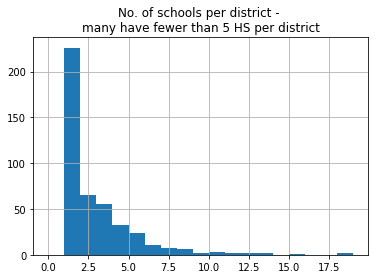

In [38]:
df_school_info_CA_schools.groupby('District').count()['School'].hist(bins=range(20))
plt.title('No. of schools per district - \nmany have fewer than 5 HS per district');

In [40]:
# Loop through each school in CA to get info

df_state = pd.DataFrame()

# Go district by district to avoid potential schools with similar names
for index_district, district in enumerate(df_school_info_CA_schools['District'].unique()):
    if index_district < 1000:
        #print(str(index_district), 'District queried: ', district)
        df_school_info_district = df_school_info_CA_schools.copy()[df_school_info_CA_schools['District']==district]
        for index, school in enumerate(df_school_info_district['School']):
            # Limit to high schools
            if index < 2000:
                try:
                    df = get_base_gs_school_info(school)
                    # Print to monitor, but limit the output
                    if index_district % 5 == 0:
                        print('District index: ', str(index_district), 'School index: ', str(index), school, df.shape, '\n -----')
                    if len(df_state.columns) < 1:
                        df_state = df.copy()
                        df_state.columns = [school]
                        index2get = df.index
                    else:
                        df_state[school] = df.copy().loc[index2get, :]
                        #df_state[school] = df
                except:
                    df_state[school] = None

            else:
                break
                
    else:
        break

# Transpose
df_state_tp = df_state.T

District index:  0 School index:  0 Envision Academy for Arts & Technology (23, 1) 
 -----


/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


District index:  5 School index:  0 Emery Secondary (23, 1) 
 -----
District index:  10 School index:  0 James Logan High (23, 1) 
 -----
District index:  15 School index:  0 Dublin High (23, 1) 
 -----
District index:  20 School index:  0 Inspire School of Arts and Sciences (23, 1) 
 -----
District index:  20 School index:  1 Chico High (23, 1) 
 -----
District index:  20 School index:  2 Pleasant Valley High (23, 1) 
 -----
District index:  25 School index:  0 Bret Harte Union High (23, 1) 
 -----
District index:  30 School index:  0 Williams Junior/Senior High (23, 1) 
 -----
District index:  35 School index:  0 Heritage High (23, 1) 
 -----
District index:  35 School index:  1 Freedom High (23, 1) 
 -----
District index:  35 School index:  2 Liberty High (23, 1) 
 -----
District index:  40 School index:  0 Dougherty Valley High (23, 1) 
 -----
District index:  40 School index:  1 California High (23, 1) 
 -----
District index:  40 School index:  2 Monte Vista High (23, 1) 
 -----
D

District index:  290 School index:  1 Adelanto High (22, 1) 
 -----
District index:  290 School index:  3 Options for Youth-Victorville Charter (23, 1) 
 -----
District index:  290 School index:  4 Silverado High (23, 1) 
 -----
District index:  290 School index:  5 Victor Valley High (23, 1) 
 -----
District index:  290 School index:  6 Cobalt Institute of Math and Science Academy (23, 1) 
 -----
District index:  295 School index:  0 Summit Leadership Academy-High Desert (23, 1) 
 -----
District index:  295 School index:  1 Mirus Secondary (22, 1) 
 -----
District index:  295 School index:  3 Oak Hills High (23, 1) 
 -----
District index:  295 School index:  4 Hesperia High (23, 1) 
 -----
District index:  295 School index:  5 Sultana High (23, 1) 
 -----
District index:  300 School index:  0 San Diego Workforce Innovation High (20, 1) 
 -----
District index:  300 School index:  1 Borrego Springs High (23, 1) 
 -----
District index:  305 School index:  0 River Valley Charter (23, 1) 


In [42]:
# Count number of rows with less than 5 null values out of the 23 targeted to scrape

print(str((df_state_tp.isnull().sum(axis=1) < 5).sum())
      +  ' GS schools info obtained out of ' 
      + str(df_state_tp.shape[0]) 
      + ' schools queried' )


no_of_schools_wlink = df_state_tp['overviewLink'].notnull().sum()
print('no. of schools with GS link: ', str(no_of_schools_wlink))

no_of_schools_wlink = df_state_tp['overviewLink'].notnull().sum()

1151 GS schools info obtained out of 1253 schools queried
no. of schools with GS link:  1165


In [43]:
df_state_tp['overviewLink'].notnull().sum()

1165

In [44]:
df_state_tp.loc[df_state_tp.isnull().sum(axis=1) > 5, :]

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,phone,fax,website,ncesId,lat,lon,overviewLink,ratingsLink,reviewsLink,schoolStatsLink
Silver Oak High Public Montessori Charter,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
MetWest High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
McClymonds High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Paradise eLearning Academy,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Maxwell Sr High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Clayton Valley Charter High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
De Anza High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
El Cerrito High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Big Picture Educational Academy,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
McLane High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [47]:
# Save csv so it's not necessary to reprocess
df_state_tp.to_csv('repo/df_state_tp_WITH_URL_191006.csv')

### Get high-level ratings using school profile page

For college readiness, test scores, advanced courses,
equity overview, race ethnicity, low income, disabilities

**Note: (API not required here)**

In [769]:
# Test query
# school = df_school_info_sd_schools_su['School'].iloc[5]
# print(school.replace(' ','-'))
# url = df_district_tp.loc[school, 'overviewLink']
# socket_read = urllib.request.urlopen(url).read()
# soup = BeautifulSoup(socket_read, 'html.parser')
# url_test = 'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/?utm_source=GSAPI&utm_medium=referral'

In [48]:
def get_high_level_ratings(url_school):

    try:
        socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
        soup = BeautifulSoup(socket_read, 'html.parser')
    
    except:
        soup = None

    rating_categories = (['College_readiness', 'Test_scores', 'Advanced_courses',
                         'Equity_overview', 'Race_ethnicity', 'Low-income_students',
                         'Students_with_Disabilities'])
        
    rating_list = list()
    for rating_cat in rating_categories:
        #print(rating_cat)
        try:
            tags = soup.find_all(href=re.compile(rating_cat))
            this_cat_rating_list = []
            for tag in tags:
                for index, child in enumerate(tag.contents):
                    if "rating" in str(child):
                        this_child = str(child)
                        rating = (int(this_child.split('--')[1].split()[0]))
                        this_cat_rating_list.append(rating)
                    else:
                        #print("no rating")
                        this_cat_rating_list.append('no_rating')

                # If there's no rating in any tag for that category, record it as None
                if False not in [i=='no_rating' for i in this_cat_rating_list]:
                    rating = None

        except:
            rating = None
            
        rating_list.append(rating)
        
    return rating_list

#### Testing with Sweetwater Union

In [ ]:
# Commented out if needed to start next loop at a certain index

# col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_district_tp.loc[:, rating] = None



In [92]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# Use enumerate option to start at a certain index and not start over
for i, url in enumerate(df_district_tp['overviewLink'], 9):
    print(i)
    #try:
#     index_school = df_district_tp.index[i]
#     df_district_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
#     print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    #except:
    #    continue


9
10
11
12
13
14
15
16
17
18
19
20


In [114]:
df_district_tp['overviewLink'].iloc[9:]

Mar Vista Senior High     https://www.greatschools.org/california/imperi...
Sweetwater High           https://www.greatschools.org/california/nation...
Montgomery Senior High    https://www.greatschools.org/california/san-di...
Name: overviewLink, dtype: object

In [117]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# Careful with this - 

start_val = 9
for i, url in enumerate(df_district_tp['overviewLink'].iloc[start_val:]):
    index_school = df_district_tp.index[i+start_val]
    print(i, index_school, url)
#     try:
#         index_school = df_district_tp.index[i]
#         df_district_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
#         no_of_values = df_district_tp.loc[index_school, col_hl_ratings].notnull().sum()
#         print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school + ' - ' + str(no_of_values))    # To monitor output
#     except:
#         continue



0 Mar Vista Senior High https://www.greatschools.org/california/imperial-beach/6289-Mar-Vista-Senior-High-School/?utm_source=GSAPI&utm_medium=referral
1 Sweetwater High https://www.greatschools.org/california/national-city/6297-Sweetwater-High-School/?utm_source=GSAPI&utm_medium=referral
2 Montgomery Senior High https://www.greatschools.org/california/san-diego/6291-Montgomery-Senior-High-School/?utm_source=GSAPI&utm_medium=referral


####  Testing with LA Unified

In [1291]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_district_tp_LA.loc[:, rating] = None
    
# for i, url in enumerate(df_district_tp_LA['overviewLink']):
#     index_school = df_district_tp_LA.index[i]
#     print(str(i+1) + ' of ' + str(len(df_district_tp_LA)) + ': ' + index_school)    # To monitor output
#     df_district_tp_LA.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)

1 of 160: High Tech LA
2 of 160: Wallis Annenberg High
3 of 160: Central City Value
4 of 160: ICEF View Park Preparatory Accelerated High
5 of 160: CATCH Prep Charter High, Inc.
6 of 160: Oscar De La Hoya Animo Charter High
7 of 160: Animo South Los Angeles Charter
8 of 160: Middle College High
9 of 160: Dr. Richard A. Vladovic Harbor Teacher Preparation Academy
10 of 160: Camino Nuevo Charter High
11 of 160: Animo Venice Charter High
12 of 160: Animo Pat Brown
13 of 160: Northridge Academy High
14 of 160: Port of Los Angeles High
15 of 160: CHAMPS - Charter HS of Arts-Multimedia & Performing
16 of 160: Alliance Judy Ivie Burton Technology Academy High
17 of 160: Alliance Collins Family College-Ready High
18 of 160: Santee Education Complex
19 of 160: South East High
20 of 160: Maywood Academy High
21 of 160: New Village Girls Academy
22 of 160: Alliance Patti And Peter Neuwirth Leadership Academy
23 of 160: Alliance Dr. Olga Mohan High
24 of 160: Animo Ralph Bunche Charter High
25 of 

#### Full CA high school data

In [ ]:
# Commented out if needed to start next loop at a certain index

# col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_state_tp.loc[:, rating] = None


In [119]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# For debugging - start at a certain row and not have to start over
# Don't use enumerate option since the url doesn't track with the option

start_val = 350
for i, url in enumerate(df_state_tp['overviewLink'].iloc[start_val:]):
    index_school = df_state_tp.index[i+start_val]
    try:
        if url is not None:
            df_state_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
            no_of_values = df_state_tp.loc[index_school, col_hl_ratings].notnull().sum()
        else:
            df_state_tp.loc[index_school, col_hl_ratings] = None
    except:
        df_state_tp.loc[index_school, col_hl_ratings] = None
    if i % 10 == 0:
        print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school + ' - ' + str(no_of_values))    # To monitor output


1 of 1253: Contreras Learning Center-Academic Leadership Community - 4
11 of 1253: Alliance Tennenbaum Family Technology High - 4
21 of 1253: Valley Academy of Arts and Sciences - 4
31 of 1253: Synergy Quantum Academy - 4
41 of 1253: Augustus F. Hawkins High B Community Health Advocates - 4
51 of 1253: Alliance Alice M. Baxter College-Ready High - 3
61 of 1253: Collegiate Charter High School of Los Angeles - 3
71 of 1253: Matrix for Success Academy - 0
81 of 1253: Grover Cleveland Charter High - 4
91 of 1253: Ulysses S. Grant Senior High - 4
101 of 1253: James Monroe High - 4
111 of 1253: University High School Charter - 4
121 of 1253: Monrovia High - 4
131 of 1253: Odyssey STEM Academy - 0
141 of 1253: Fremont Academy of Engineering and Design - 4
151 of 1253: Pioneer High - 4
161 of 1253: Opportunities for Learning - Santa Clarita - 4
171 of 1253: John A. Rowland High - 4
181 of 1253: Mira Costa High - 4
191 of 1253: Madera South High - 4
201 of 1253: San Rafael High - 4
211 of 1253:

In [98]:
# Something to fix if there's time
# df_state_tp.iloc[360:365, :]

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,ratingsLink,reviewsLink,schoolStatsLink,college_readiness,test_scores,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities
Alliance Tennenbaum Family Technology High,25748,Alliance Tennenbaum Family Technology High,charter,9-12,408,6,4,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,10,10,None,None,None,10,None
"Math, Science, & Technology Magnet Academy at Roosevelt High",2496,Windsor Hills Math Science,public,K-5,530,4,4,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,2,4,None,4,None,4,None
Esteban Torres East LA Performing Arts Magnet,None,None,None,None,None,None,None,None,None,None,...,None,None,None,8,9,None,10,None,9,None
Humanitas Academy of Art and Technology at Esteban E. Torres High No. 4,25437,Humanitas Academy Of Art And Technology At Est...,public,9-12,493,4,NaN,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,None,None,None,None,None,None,None
Social Justice Leadership Academy at Esteban E. Torres High No. 5,25474,Social Justice Leadership Academy At Esteban E...,public,9-12,406,3,NaN,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,4,5,None,4,None,4,None


In [130]:
# Count number of rows with some null values out of the 30 targeted to scrape
# print(str((df_state_tp.isnull().sum(axis=1) < 5).sum())
#       +  ' GS schools info obtained out of ' 
#       + str(df_state_tp.shape[0]) 
#       + ' schools queried' )

no_of_schools_w_4HLratings = (df_state_tp.loc[:, col_hl_ratings].notnull().sum(axis=1) >=3).sum()
print(str(no_of_schools_w_4HLratings) + ' GS schools with at least 3 of the 4 high-level ratings out of ' + str(no_of_schools_wlink) + ' with a link')

1028 GS schools with at least 3 of the 4 high-level ratings out of 1165 with a link


In [125]:
# CSV to save I don't have to start over
df_state_tp.to_csv('repo/df_state_tp_WITH_URL-HLdone997schoolsWinfo_191006.csv')

In [126]:
df_state_tp.tail()

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,ratingsLink,reviewsLink,schoolStatsLink,college_readiness,test_scores,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities
Woodland Senior High,7829,Woodland Senior High School,public,9-12,1318,5,3,Woodland,CA,1041,...,https://www.greatschools.org/california/woodla...,https://www.greatschools.org/california/woodla...,https://www.greatschools.org/california/woodla...,5,4,None,3,None,3,None
Lindhurst High,7771,Lindhurst High School,public,9-12,1122,3,4,Olivehurst,CA,1032,...,https://www.greatschools.org/california/oliveh...,https://www.greatschools.org/california/oliveh...,https://www.greatschools.org/california/oliveh...,3,3,None,2,None,2,None
Marysville Charter Academy for the Arts,11901,Marysville Charter Academy For The Arts,charter,7-12,376,8,5,Marysville,CA,1032,...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,9,8,None,8,None,8,None
Marysville High,7773,Marysville High School,public,9-12,893,5,4,Marysville,CA,1032,...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,8,3,None,2,None,2,None
Wheatland Union High,7785,Wheatland Union High School,public,9-12,707,5,3,Wheatland,CA,1035,...,https://www.greatschools.org/california/wheatl...,https://www.greatschools.org/california/wheatl...,https://www.greatschools.org/california/wheatl...,7,5,None,3,None,3,None


### Obtain GS details on teacher and low income data

In [141]:
def get_school_page_doc(url_school):
    try:
        socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
        soup = BeautifulSoup(socket_read, 'html.parser')
        school_page_doc = soup.get_text()
    except:
        school_page_doc = None
    return school_page_doc

In [143]:
def get_relevant_texts_teachers(my_text):
    try:
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 300
        for this_match in range(len(my_str_loc)):
            #if "\"label\"" in school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]:
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
    except:
        relevant_text = None
    return relevant_text

In [144]:
# This was arbitrarily chosen because it's the middle category
# but I tried other things and this seemed to work well to get the right section
# teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')

In [145]:
def get_ratios_for_staff(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        ratio_loc = teacher_text.replace('\n', '').find(':', text2get_loc_end)
        student_to_one_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:ratio_loc].strip())
    except:
        student_to_one_staff = None
    return student_to_one_staff


In [146]:
def get_percentages_for_staff(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        character_loc = teacher_text.replace('\n', '').find('%', text2get_loc_end)
        percent_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:character_loc].strip())
    except:
        percent_staff = None
    return percent_staff

In [147]:
def get_salary(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        character_loc = teacher_text.replace('\n', '').find('$', text2get_loc_end)
        end_of_salary_loc = teacher_text.replace('\n', '').find(' ', character_loc)
        salary = int(teacher_text.replace('\n', '')[character_loc+1:end_of_salary_loc].replace(',',''))
    except:
        salary = None
    return salary

In [148]:
# Testing
# Add this to individual school info and then dataframe
# (get_ratios_for_staff('Students per teacher'),
#  get_ratios_for_staff('Students per counselor'),
#  get_percentages_for_staff('Percentage of teachers with 3 or more years experience'),
#  get_percentages_for_staff('% of full time teachers who are certified '),
#  get_salary('Average teacher salary'))

In [149]:
def get_pct_lowincome_students(school_page_doc):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        #min_max_to_look = 250  # use for other things
        min_max_to_look = 100
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if '"breakdown":"Low-income","breakdown_in_english":"Economically disadvantaged"' in relevant_text:
                #print('   =============   ' + str(counter) + '   === (no. of low income?) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
        
    try:
        str2find = '"percentage":'
        str2find_loc_start = relevant_text.find(str2find)
        str2find_loc_end = str2find_loc_start + len(str2find)
        pct_low_income_loc_end = relevant_text.find(',', str2find_loc_end)
        pct_low_income = int(relevant_text[str2find_loc_end:pct_low_income_loc_end].strip('"'))
    except:
        pct_low_income = None
    
    return pct_low_income

In [150]:
def get_lowincome_test_scores_overview(school_page_doc):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 400
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and counter==0:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
        
    try:  
        str2find = '"All students","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_AS = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_AS = None

    try:
        str2find = '"Economically disadvantaged","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_LI = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_LI = None

    try:
        str2find = '"Not economically disadvantaged","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_notLI = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_notLI = None

    return (score_AS, score_LI, score_notLI)

In [151]:
def get_lowincome_test_scores_for_subject(school_page_doc, subject):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 350
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and subject in relevant_text:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
    
    # Get all students info
    try:
        str2find = '"All students","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_AS = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_AS = None

    try:
        str2find_no_students = '"number_students_tested":'
        no_students_loc_start = relevant_text.find(str2find_no_students, low_inc_score_loc_end)
        no_students_loc_end = no_students_loc_start + len(str2find_no_students)
        #score_start = no_students_loc_end + 1
        score_end = relevant_text.find(',', no_students_loc_end)
        no_students_tested_AS = int(relevant_text[no_students_loc_end:score_end])
    except:
        no_students_tested_AS = None
    
    # Get low income info
    try:
        str2find = '"Economically disadvantaged","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_LI = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_LI = None
        
    try:    
        str2find_no_students = '"number_students_tested":'
        no_students_loc_start = relevant_text.find(str2find_no_students, low_inc_score_loc_end)
        no_students_loc_end = no_students_loc_start + len(str2find_no_students)
        #score_start = no_students_loc_end + 1
        score_end = relevant_text.find(',', no_students_loc_end)
        no_students_tested_LI = int(relevant_text[no_students_loc_end:score_end])
    except:
        no_students_tested_LI = None
    
    return (score_AS, no_students_tested_AS, score_LI, no_students_tested_LI)

In [152]:
def get_lowincome_gradrates_college_eligibility(school_page_doc, grad_category):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 300
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and grad_category in relevant_text:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
                
    except:
        relevant_text = None

    try:
        str2find = '"All students","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_AS = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_AS = None

    try:
        str2find = '"Low-income","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_LI = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_LI = None

    return (score_AS, score_LI)

#### Testing with Sweetwater Union

In [160]:
# Initiate teacher rating columns
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
for rating in col_teacher_ratings:
    df_district_tp.loc[:, rating] = None

# Initiate low income data columns
col_lowincome_ratings = (['test_score_rating_allStudents',
                          'test_score_rating_LIstudents',
                          'test_score_rating_notLIstudents',
                          'test_scores_english_allStudents',
                          'test_scores_english_allStudents_n_students',
                          'test_scores_english_LIstudents',
                          'test_scores_english_LIstudents_n_students',
                          'test_scores_math_allStudents',
                          'test_scores_math_allStudents_n_students',
                          'test_scores_math_LIstudents',
                          'test_scores_math_LIstudents_n_students',
                          'graduation_rates_UCCSU_eligibility_allStudents',
                          'graduation_rates_UCCSU_eligibility_LIstudents',
                          'graduation_rates_gradRates_eligibility_allStudents',
                          'graduation_rates_gradRates_eligibility_LIstudents',
                          'pct_LI_students'])
for rating in col_lowincome_ratings:
    df_district_tp.loc[:, rating] = None

    

start_val = 3
end_val = 5
for i, url in enumerate(df_district_tp['overviewLink'].iloc[start_val:end_val]):
    index_school = df_district_tp.index[i+start_val]
     
# for i, url in enumerate(df_district_tp['overviewLink']):
#     index_school = df_district_tp.index[i]
    print(str(i+1+start_val) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    school_page_doc = get_school_page_doc(url)
    
    # Detailed teacher info
    df_district_tp.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
    df_district_tp.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
    df_district_tp.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
    df_district_tp.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
    df_district_tp.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')
    
    # Detailed low income info
    df_district_tp.loc[index_school, col_lowincome_ratings[0:3]] = get_lowincome_test_scores_overview(school_page_doc)
    df_district_tp.loc[index_school, col_lowincome_ratings[3:7]] = get_lowincome_test_scores_for_subject(school_page_doc, 'English Language Arts')
    df_district_tp.loc[index_school, col_lowincome_ratings[7:11]] = get_lowincome_test_scores_for_subject(school_page_doc, 'Math')
    df_district_tp.loc[index_school, col_lowincome_ratings[11:13]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'UC/CSU eligibility')
    df_district_tp.loc[index_school, col_lowincome_ratings[13:15]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'Graduation rates')
    df_district_tp.loc[index_school, col_lowincome_ratings[15]] = get_pct_lowincome_students(school_page_doc)

print('done getting schools in this set')

4 of 12: Castle Park Senior High
5 of 12: Eastlake High
done getting schools in this set


#### Testing with LA Unified

In [227]:
# col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
# # Initiate columns
# for rating in col_teacher_ratings:
#     df_district_tp_LA.loc[:, rating] = None
    
# for i, url in enumerate(df_district_tp_LA['overviewLink']):
#     index_school = df_district_tp_LA.index[i]
#     print(str(i+1) + ' of ' + str(len(df_district_tp_LA)) + ': ' + index_school)    # To monitor output
#     school_page_doc = get_school_page_doc(url)
#     #teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
#     df_district_tp_LA.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
#     # print(get_ratios_for_staff('Students per teacher'))
#     df_district_tp_LA.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
#     df_district_tp_LA.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
#     df_district_tp_LA.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
#     df_district_tp_LA.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')

#### Full CA high school data

In [ ]:
# Initiate teacher rating columns
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
for rating in col_teacher_ratings:
    df_state_tp.loc[:, rating] = None

# Initiate low income data columns
col_lowincome_ratings = (['test_score_rating_allStudents',
                          'test_score_rating_LIstudents',
                          'test_score_rating_notLIstudents',
                          'test_scores_english_allStudents',
                          'test_scores_english_allStudents_n_students',
                          'test_scores_english_LIstudents',
                          'test_scores_english_LIstudents_n_students',
                          'test_scores_math_allStudents',
                          'test_scores_math_allStudents_n_students',
                          'test_scores_math_LIstudents',
                          'test_scores_math_LIstudents_n_students',
                          'graduation_rates_UCCSU_eligibility_allStudents',
                          'graduation_rates_UCCSU_eligibility_LIstudents',
                          'graduation_rates_gradRates_eligibility_allStudents',
                          'graduation_rates_gradRates_eligibility_LIstudents',
                          'pct_LI_students'])
for rating in col_lowincome_ratings:
    df_state_tp.loc[:, rating] = None
    
# Set start and end to avoid hangups
start_val = 0
end_val = len(df_state_tp)
for i, url in enumerate(df_state_tp['overviewLink'].iloc[start_val:end_val]):
    index_school = df_state_tp.index[i+start_val]
    #print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school)    # To monitor output
    # Monitor output but don't print everything
    if i % 10==0:
        print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school)    # To monitor output
    school_page_doc = get_school_page_doc(url)
    
    # Detailed teacher info
    df_state_tp.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
    df_state_tp.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
    df_state_tp.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
    df_state_tp.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
    df_state_tp.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')
    
    # Detailed low income info
    df_state_tp.loc[index_school, col_lowincome_ratings[0:3]] = get_lowincome_test_scores_overview(school_page_doc)
    df_state_tp.loc[index_school, col_lowincome_ratings[3:7]] = get_lowincome_test_scores_for_subject(school_page_doc, 'English Language Arts')
    df_state_tp.loc[index_school, col_lowincome_ratings[7:11]] = get_lowincome_test_scores_for_subject(school_page_doc, 'Math')
    df_state_tp.loc[index_school, col_lowincome_ratings[11:13]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'UC/CSU eligibility')
    df_state_tp.loc[index_school, col_lowincome_ratings[13:15]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'Graduation rates')
    df_state_tp.loc[index_school, col_lowincome_ratings[15]] = get_pct_lowincome_students(school_page_doc)

print('done getting schools in this set')

1 of 1253: Envision Academy for Arts & Technology
1 of 1253: Envision Academy for Arts & Technology
2 of 1253: Alameda High
3 of 1253: Alternatives in Action
4 of 1253: Albany High
5 of 1253: Berkeley High
6 of 1253: Castro Valley High
7 of 1253: Emery Secondary
8 of 1253: American High
9 of 1253: Irvington High
10 of 1253: John F. Kennedy High
11 of 1253: Mission San Jose High
11 of 1253: Mission San Jose High
12 of 1253: Washington High
13 of 1253: Leadership Public Schools - Hayward
14 of 1253: Silver Oak High Public Montessori Charter
15 of 1253: Hayward High
16 of 1253: Mt. Eden High
17 of 1253: Tennyson High
18 of 1253: Granada High
19 of 1253: Livermore High
20 of 1253: Newark Memorial High
21 of 1253: James Logan High
21 of 1253: James Logan High
22 of 1253: Oakland Unity High
23 of 1253: MetWest High
24 of 1253: Lighthouse Community Charter High
25 of 1253: McClymonds High
26 of 1253: American Indian Public High
27 of 1253: Oakland Charter High
28 of 1253: ARISE High
29 of 125

238 of 1253: William J. (Pete) Knight High
239 of 1253: Eastside High
240 of 1253: Academies of the Antelope Valley
241 of 1253: Antelope Valley High
241 of 1253: Antelope Valley High
242 of 1253: Palmdale High
243 of 1253: Quartz Hill High
244 of 1253: Littlerock High
245 of 1253: Lancaster High
246 of 1253: Desert Sands Charter
247 of 1253: Arcadia High
248 of 1253: Azusa High
249 of 1253: Gladstone High
250 of 1253: Baldwin Park High
251 of 1253: Sierra Vista High
251 of 1253: Sierra Vista High
252 of 1253: Opportunities for Learning - Baldwin Park
253 of 1253: Bassett Senior High
254 of 1253: Bellflower High
255 of 1253: Mayfair High
256 of 1253: Beverly Hills High
257 of 1253: Bonita High
258 of 1253: San Dimas High
259 of 1253: Burbank High
260 of 1253: Family First Charter
261 of 1253: New Opportunities Charter
261 of 1253: New Opportunities Charter
262 of 1253: Hawthorne High
263 of 1253: Lawndale High
264 of 1253: Leuzinger High
265 of 1253: Charter Oak High
266 of 1253: Clare

400 of 1253: Academy of Medical Arts at Carson High
401 of 1253: Alliance Alice M. Baxter College-Ready High
401 of 1253: Alliance Alice M. Baxter College-Ready High
402 of 1253: Humanities and Arts (HARTS) Academy of Los Angeles
403 of 1253: Contreras Learning Center-School of Social Justice
404 of 1253: Early College Academy-LA Trade Tech College
405 of 1253: Valor Academy High
406 of 1253: Camino Nuevo High #2
407 of 1253: Boyle Heights Science, Technology, Engineering and Math Magnet
408 of 1253: NAVA College Preparatory Academy
409 of 1253: TEACH Tech Charter High
410 of 1253: Sylmar Biotech Health and Engineering Magnet
411 of 1253: Collegiate Charter High School of Los Angeles
411 of 1253: Collegiate Charter High School of Los Angeles
412 of 1253: University Preparatory Value High
413 of 1253: Bert Corona Charter High
414 of 1253: Ednovate - East College Prep
415 of 1253: Rise Kohyang High
416 of 1253: WISH Academy High
417 of 1253: Ednovate - Esperanza College Prep
418 of 1253:

612 of 1253: Napa High
613 of 1253: Saint Helena High
614 of 1253: Bitney Prep High
615 of 1253: EPIC de Cesar Chavez
616 of 1253: John Muir Charter
617 of 1253: Sierra Academy of Expeditionary Learning
618 of 1253: Bear River High
619 of 1253: Nevada Union High
620 of 1253: Samueli Academy
621 of 1253: College and Career Preparatory Academy
621 of 1253: College and Career Preparatory Academy
622 of 1253: Unity Middle College High
623 of 1253: Ednovate - Legacy College Prep.
624 of 1253: Orange County Workforce Innovation High
625 of 1253: Cypress High
626 of 1253: Anaheim High
627 of 1253: Oxford Academy
628 of 1253: Katella High
629 of 1253: Loara High
630 of 1253: Magnolia High
631 of 1253: Savanna High
631 of 1253: Savanna High
632 of 1253: Western High
633 of 1253: Brea-Olinda High
634 of 1253: San Juan Hills High
635 of 1253: Capistrano Valley High
636 of 1253: Aliso Niguel High
637 of 1253: Tesoro High
638 of 1253: San Clemente High
639 of 1253: Dana Hills High
640 of 1253: Buen

In [ ]:
# No. of schools with at least 5 of the 21 detailed ratings
no_of_schools_wdetailed_ratings = (df_state_tp.loc[:, col_teacher_ratings + col_lowincome_ratings].isnull().sum(axis=1) < 5).sum()
print('', str(no_of_schools_wdetailed_ratings))

In [ ]:
print(str(no_of_schools_wdetailed_ratings) + ' GS schools with detailed ratings out of ' 
      + str(no_of_schools_wlink) + ' with a link')

## Merge datasets

In [ ]:
#  Merge on this!


# From school info: NCESDist	NCESSchool  :  622710 + 11365
# On GS info: ncesId:   62271011365

# And filter out unrated schools (gsRating = None)

In [466]:
# Merge on school and zip code due to same named schools

# Need zip code in GS data
df_temp = df_state_tp['address'].str.split(expand=True)
col_index4zip = len(df_temp.columns) - df_temp.isnull().sum(axis=1) - 1

zipcode_list = list()
for i, col in enumerate(col_index4zip):
    if col != -1:
        zipcode = df_temp.iloc[i, col]
    else:
        zipcode = df_temp.iloc[i, 8]
    try:
        zipcode_list.append(int(zipcode))
    except:
        zipcode_list.append(None)
        
df_state_tp['zip_code_GS'] = zipcode_list
df_state_tp['schoolname4merge'] = df_state_tp.index

In [470]:
# Merge great schools and school info on zip code
df_state_info_gs = pd.merge(df_school_info, df_state_tp, how='inner',
                            left_on=['School', 'zip_code'],
                            right_on=['schoolname4merge', 'zip_code_GS'])

# Inspection showed a handful of schools in df_school_info with duplicate values for some reason
df_state_info_gs = df_state_info_gs.drop_duplicates(subset=['School', 'Street'], keep='last')

In [472]:
# Merge great schools, school info and demographic info on zip code
df_state_info_gs_census = pd.merge(df_state_info_gs, df_census,
                                      how='inner', left_on='zip_code', right_index=True)

In [473]:
print('No. of schools with census info \n(note: schools with same zip codes will have same demographic info:\n', df_state_info_gs_census.shape)

No. of schools with census info 
(note: schools with same zip codes will have same demographic info:
 (184, 217)


## Exploratory Data Analysis

Focus is on understanding our target: college eligibility of low income (LI) students across high schools obtained from GS data.

- What does the variability of the target look like? 
- What features (demographic or GS data) might be correlated with the target?
- What features are correlated with each other?

### Variability of target

In [510]:
target_col = 'graduation_rates_UCCSU_eligibility_LIstudents'

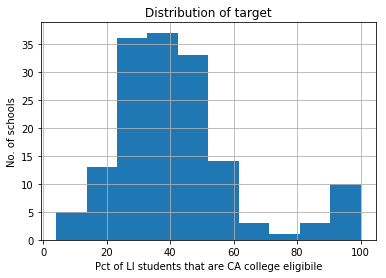

In [481]:
# Change target from integer to float to plot histogram
df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'] = pd.to_numeric(df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].copy(), 'float')

f, ax1 = plt.subplots()
ax1 = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].hist();
ax1.set_title('Distribution of target')
ax1.set_xlabel('Pct of LI students that are CA college eligibile')
ax1.set_ylabel('No. of schools');

### Features correlated with target

In [590]:
def return_correlation_matrix(df, col_of_features, target):
    try:
        df4corr = df.loc[:, col_of_features.tolist() + [target]]
    except:
        df4corr = df.loc[:, col_of_features + [target]]
    return df4corr.corr()

#### Census "%" columns

In [533]:
# Census columns that start with '%'
col_census_pct = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('%')]
len(col_census_pct)

98

In [534]:
df_state_info_gs_census.loc[:, col_census_pct].head()

,%; INCOME_BENEFITS - w/ retirement income_x,%; INCOME_BENEFITS - w/ cash public assistance income_x,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
0,8,4.5,62.7,62.4,55.6,6.8,0.3,37.3,11.0,54.6,...,18.8,30.3,23.3,22.8,25.5,31.0,28.9,39.3,17.1,39.3
1,14.9,3.2,69.3,67.8,62.2,5.6,1.5,30.7,8.3,65.4,...,6.2,11.4,12.1,11.2,10.9,11.2,11.6,9.1,8.8,19.8
2,11.5,13.5,61.4,61.4,52.1,9.4,0.0,38.6,15.2,53.4,...,20.4,32.8,42.7,42.5,40.0,28.0,29.2,17.4,30.9,43.6
23,11.5,13.5,61.4,61.4,52.1,9.4,0.0,38.6,15.2,53.4,...,20.4,32.8,42.7,42.5,40.0,28.0,29.2,17.4,30.9,43.6
3,13.6,1,68.8,68.7,64.5,4.2,0.1,31.2,6.2,62.7,...,6.7,11.4,11.1,10.6,9.4,11.5,12.3,6.2,8.5,25.3


In [535]:
# Broad categories in pct census columns
set([i.split('-')[0] for i in col_census_pct.tolist()])

{'%; %',
 '%; EMPLOY_STATUS ',
 '%; HEALTH_INS_COVERAGE ',
 '%; INCOME_BENEFITS ',
 '%; INDUSTRY ',
 '%; OCCUPATION ',
 '%; WORKER_CLASS ',
 '%; WORK_COMMUTE '}

In [536]:
df_corr_census_pct = return_correlation_matrix(df_state_info_gs_census, col_census_pct, target_col)

In [544]:
# Top correlated features
df_corr_census_pct.sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents', ascending=False)['graduation_rates_UCCSU_eligibility_LIstudents'].head(10)

graduation_rates_UCCSU_eligibility_LIstudents                                                                                                      1.000000
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)                                                                0.481849
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services    0.293205
%; INCOME_BENEFITS - w/ earnings                                                                                                                   0.279022
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force                                                                      0.273271
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information                                                                                   0.266472
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force          

In [541]:
# Top anti-correlated features
df_corr_census_pct.sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents')['graduation_rates_UCCSU_eligibility_LIstudents'].head(10)

%; INCOME_BENEFITS - w/ Social Security                                                        -0.360336
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone                    -0.334939
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force                                     -0.265283
%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Government workers                    -0.240156
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage   -0.223936
%; INCOME_BENEFITS - Families - $50,000 to $74,999                                             -0.202861
%; INCOME_BENEFITS - w/ retirement income_y                                                    -0.198559
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration                     -0.196176
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade                              -0.181458
%; INCOME_BENEFITS - Families - $75,000 to $99,999     

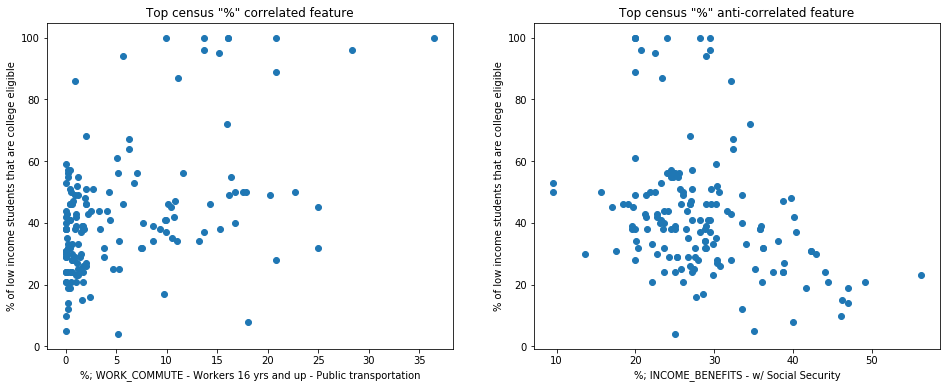

In [556]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.scatter(df_state_info_gs_census['%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)'],
            df_state_info_gs_census[target_col]);
ax1.set_title('Top census "%" correlated feature')
ax1.set_xlabel('%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation')
ax1.set_ylabel('% of low income students that are college eligible')

ax2.scatter(df_state_info_gs_census['%; INCOME_BENEFITS - w/ Social Security'],
           df_state_info_gs_census[target_col]);
ax2.set_title('Top census "%" anti-correlated feature')
ax2.set_xlabel('%; INCOME_BENEFITS - w/ Social Security')
ax2.set_ylabel('% of low income students that are college eligible');

#### Census income columns

In [491]:
# Census columns that start with 'Est'
col_census_est = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('Est')]

In [571]:
# Change so that all are numeric/float
for col in col_census_est:
    df_state_info_gs_census[col] = pd.to_numeric(df_state_info_gs_census[col].copy(), 'float')

In [572]:
col_census_est

Index(['Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - Total households - Mean household income ($)',
       'Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       'Est.; INCOME_BENEFITS - Families - Median family income ($)',
       'Est.; INCOME_BENEFITS - Families - Mean family income ($)',
       'Est.; INCOME_BENEFITS - Per capita income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)'],
      dtype='object')

In [575]:
df_state_info_gs_census[col_census_est].head()

,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - Total households - Mean household income ($),Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($),Est.; INCOME_BENEFITS - w/ retirement income,Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income,Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($),Est.; INCOME_BENEFITS - Families - Median family income ($),Est.; INCOME_BENEFITS - Families - Mean family income ($),Est.; INCOME_BENEFITS - Per capita income ($),Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($),Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)
0,32993,55911,12978.0,659,29027.0,368,5055.0,38980,67067,32425,29122.0,51831.0
1,72884,99612,17113.0,3804,32115.0,827,4632.0,88693,118416,41592,52815.0,67936.0
2,31903,43104,12293.0,1086,19269.0,1268,5347.0,34633,44970,13082,18963.0,28948.0
23,31903,43104,12293.0,1086,19269.0,1268,5347.0,34633,44970,13082,18963.0,28948.0
3,80970,105995,17921.0,1085,36487.0,83,4229.0,95880,118328,42019,49099.0,74376.0


In [592]:
df_corr_census_est = return_correlation_matrix(df_state_info_gs_census, col_census_est, target_col)

In [578]:
# Top correlated features
df_corr_census_est.sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents', ascending=False)['graduation_rates_UCCSU_eligibility_LIstudents'].head(5)

graduation_rates_UCCSU_eligibility_LIstudents                               1.000000
Est.; INCOME_BENEFITS - w/ cash public assistance income                    0.238561
Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)    0.210291
Est.; INCOME_BENEFITS - Total households - Mean household income ($)        0.178344
Est.; INCOME_BENEFITS - Total households - Median household income ($)      0.165582
Name: graduation_rates_UCCSU_eligibility_LIstudents, dtype: float64

In [579]:
# Top anti-correlated features
df_corr_census_est.sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents')['graduation_rates_UCCSU_eligibility_LIstudents'].head(3)

Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)                        -0.067702
Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)                            0.081513
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)    0.107833
Name: graduation_rates_UCCSU_eligibility_LIstudents, dtype: float64

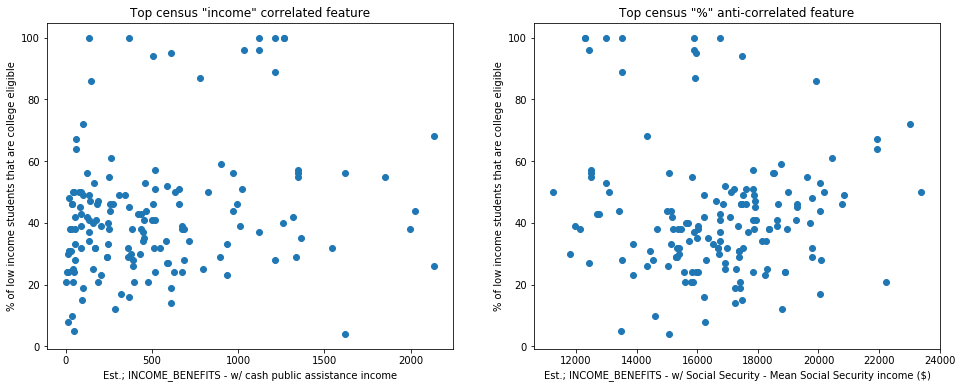

In [638]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.scatter(df_state_info_gs_census['Est.; INCOME_BENEFITS - w/ cash public assistance income'],
            df_state_info_gs_census[target_col]);
ax1.set_title('Top census "income" correlated feature')
ax1.set_xlabel('Est.; INCOME_BENEFITS - w/ cash public assistance income')
ax1.set_ylabel('% of low income students that are college eligible')

ax2.scatter(df_state_info_gs_census['Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)'],
           df_state_info_gs_census[target_col]);
ax2.set_title('Top census "%" anti-correlated feature')
ax2.set_xlabel('Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)')
ax2.set_ylabel('% of low income students that are college eligible');

Text(0,0.5,'% of low income students that are college eligible')

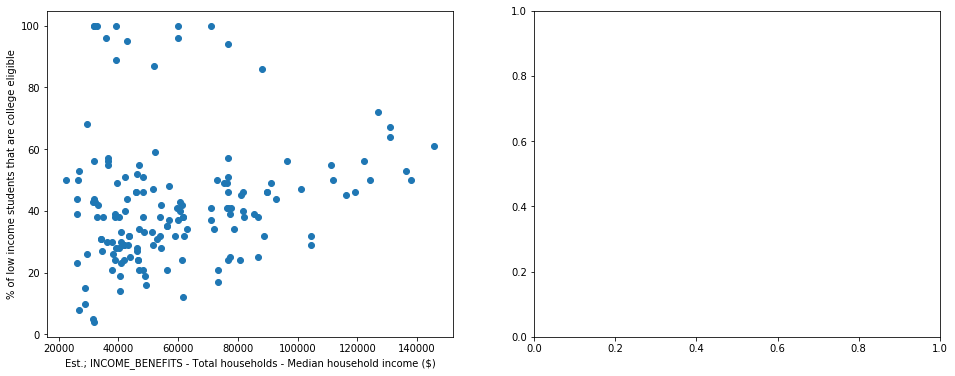

In [636]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.scatter(df_state_info_gs_census['Est.; INCOME_BENEFITS - Total households - Median household income ($)'],
            df_state_info_gs_census[target_col]);
# ax1.set_title('Top census "%" correlated feature')
ax1.set_xlabel('Est.; INCOME_BENEFITS - Total households - Median household income ($)')
ax1.set_ylabel('% of low income students that are college eligible')


#### GS high level columns

In [598]:
# High level GS school rating columns
col_gs_hl_ratings = ['gsRating'] + col_hl_ratings

# Change so that all are numeric/float
for col in col_gs_hl_ratings:
    df_state_info_gs_census[col] = pd.to_numeric(df_state_info_gs_census[col].copy(), 'float')

In [599]:
col_gs_hl_ratings

['gsRating',
 'college_readiness',
 'test_scores',
 'advanced_courses',
 'equity_overview',
 'race_ethnicity',
 'low_income',
 'disabilities']

In [600]:
df_corr_gs_hl = return_correlation_matrix(df_state_info_gs_census, col_gs_hl_ratings, target_col)

In [602]:
# Top correlated features
df_corr_gs_hl.sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents', ascending=False)['graduation_rates_UCCSU_eligibility_LIstudents'].head(5)

graduation_rates_UCCSU_eligibility_LIstudents    1.000000
low_income                                       0.490058
equity_overview                                  0.474443
test_scores                                      0.378722
gsRating                                         0.328398
Name: graduation_rates_UCCSU_eligibility_LIstudents, dtype: float64

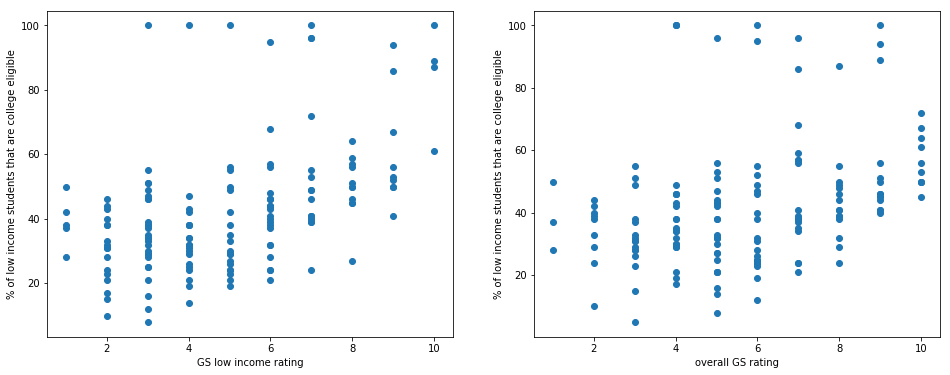

In [634]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.scatter(df_state_info_gs_census['low_income'],
            df_state_info_gs_census[target_col]);
ax1.set_xlabel('GS low income rating');
ax1.set_ylabel('% of low income students that are college eligible');

ax2.scatter(df_state_info_gs_census['gsRating'],
            df_state_info_gs_census[target_col]);
ax2.set_xlabel('overall GS rating');
ax2.set_ylabel('% of low income students that are college eligible');

#### GS teacher columns

In [587]:
col_teacher_ratings

['students_per_teacher',
 'students_per_counselor',
 'pct_teachers_3years_or_more',
 'pct_teachers_who_r_certified',
 'avg_teacher_salary']

In [605]:
# Change so that all are numeric/float
for col in col_teacher_ratings:
    df_state_info_gs_census[col] = pd.to_numeric(df_state_info_gs_census[col].copy(), 'float')

In [606]:
df_corr_gs_teacher = return_correlation_matrix(df_state_info_gs_census, col_teacher_ratings, target_col)

In [608]:
# Top correlated features
df_corr_gs_teacher.sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents', ascending=False)['graduation_rates_UCCSU_eligibility_LIstudents'].head(5)

graduation_rates_UCCSU_eligibility_LIstudents    1.000000
students_per_counselor                           0.069521
students_per_teacher                             0.046193
pct_teachers_who_r_certified                    -0.173681
avg_teacher_salary                              -0.178537
Name: graduation_rates_UCCSU_eligibility_LIstudents, dtype: float64

#### GS low income columns

In [623]:
# Need to remove target from this list without altering original list
col_lowincome_ratings_notarget = col_lowincome_ratings[:]
col_lowincome_ratings_notarget.remove('graduation_rates_UCCSU_eligibility_LIstudents')

In [624]:
col_lowincome_ratings_notarget

['test_score_rating_allStudents',
 'test_score_rating_LIstudents',
 'test_score_rating_notLIstudents',
 'test_scores_english_allStudents',
 'test_scores_english_allStudents_n_students',
 'test_scores_english_LIstudents',
 'test_scores_english_LIstudents_n_students',
 'test_scores_math_allStudents',
 'test_scores_math_allStudents_n_students',
 'test_scores_math_LIstudents',
 'test_scores_math_LIstudents_n_students',
 'graduation_rates_UCCSU_eligibility_allStudents',
 'graduation_rates_gradRates_eligibility_allStudents',
 'graduation_rates_gradRates_eligibility_LIstudents',
 'pct_LI_students']

In [625]:
# Change so that all are numeric/float
for col in col_lowincome_ratings:
    df_state_info_gs_census[col] = pd.to_numeric(df_state_info_gs_census[col].copy(), 'float')

In [629]:
df_corr_gs_LI = return_correlation_matrix(df_state_info_gs_census, col_lowincome_ratings_notarget, target_col)

In [630]:
# Top correlated features
df_corr_gs_LI.sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents', ascending=False)['graduation_rates_UCCSU_eligibility_LIstudents']

graduation_rates_UCCSU_eligibility_LIstudents         1.000000
graduation_rates_UCCSU_eligibility_allStudents        0.929880
test_scores_math_LIstudents                           0.504071
test_score_rating_LIstudents                          0.450744
test_scores_english_LIstudents                        0.432272
test_scores_math_allStudents                          0.386899
test_scores_english_allStudents                       0.331818
test_score_rating_allStudents                         0.313431
test_score_rating_notLIstudents                       0.214651
test_scores_math_allStudents_n_students               0.096068
pct_LI_students                                       0.070308
test_scores_english_allStudents_n_students            0.003836
graduation_rates_gradRates_eligibility_LIstudents    -0.046217
test_scores_math_LIstudents_n_students               -0.053713
graduation_rates_gradRates_eligibility_allStudents   -0.076280
test_scores_english_LIstudents_n_students            -0

Text(0,0.5,'% of low income students that are college eligible')

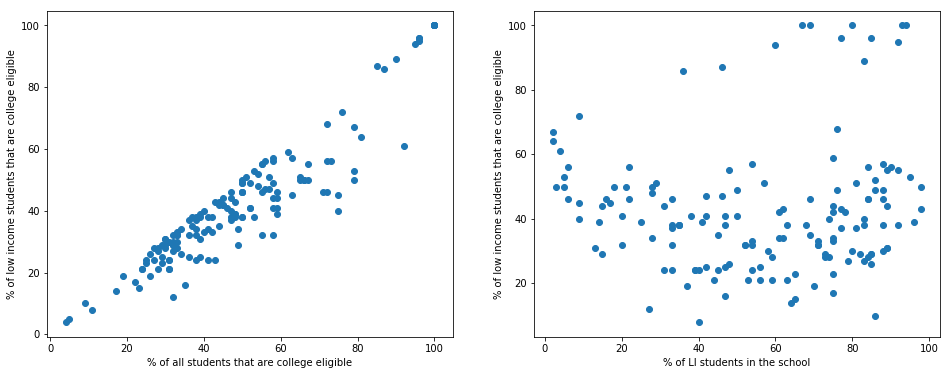

In [632]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.scatter(df_state_info_gs_census['graduation_rates_UCCSU_eligibility_allStudents'],
            df_state_info_gs_census[target_col]);
ax1.set_xlabel('% of all students that are college eligible')
ax1.set_ylabel('% of low income students that are college eligible')

ax2.scatter(df_state_info_gs_census['pct_LI_students'],
            df_state_info_gs_census[target_col]);
ax2.set_xlabel('% of LI students in the school')
ax2.set_ylabel('% of low income students that are college eligible')

#### Things learned from EDA 

While Pearson correlation is limited, especially when relationships are non-linear, some statements can be made.

1. GS data shows that schools where most students do well also have low-income students that do well.
2. Notable GS features that do *not* correlate with percentage of LI students that are college eligible: 
    - percent of LI students in the school
    - avg. teacher salary
    - percent of teachers certified
3. The high level low income GS rating was correlated with the percentage of LI students that are college eligible but Pearson correlation was only 0.49.
4. Census/demographic data may provide additional value in terms of predicting the percentage of LI students that are college eligible in a given high school. For example, while not immediately intuitive, the percentage of workers in a zip code who use public transportation is a feature that shows a correlation of 0.48 with a school's percentage of LI students that are college eligible. This is similar to the correlation described in #3.

The limitations with Pearson can be addressed further with feature engineering and modeling in the next section.

## Feature engineering and regression modeling

Steps to consider and links to tutorials

- feature transformation (e.g. [polynominal terms](https://towardsdatascience.com/polynomial-regression-bbe8b9d97491)) (do this before [rescaling](https://datascience.stackexchange.com/questions/9020/do-i-have-to-standardize-my-new-polynomial-features))
- [rescaling features](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
- [feature selection](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e) and independence of features
- [regularization](https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/)


In [640]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

### "Base" model with one feature and before any feature engineering 

In [705]:
def return_model_fitted(df, X_feature_list, y_feature, test_size_value):
    
    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = df[X_feature_list + [y_feature]].notnull().sum(axis=1)==(len(X_feature_list) + 1)
    
    df_clean = df.copy().loc[k_rows2keep, X_feature_list + [y_feature]]
    
    if len(X_feature_list)==1:
        X = df_clean[X_feature_list[0]].copy().values.reshape(-1,1)
        y = df_clean[y_feature].copy().values.reshape(-1,1)
    else:
        X = df_clean[X_feature_list].copy().values
        y = df_clean[y_feature].copy().values

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_value)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    return reg, X_train, X_test, y_train, y_test

In [706]:
X_feature_list = (['%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)'])
y = 'graduation_rates_UCCSU_eligibility_LIstudents'
test_size = 0.4

(reg_1f_base, X_train_base, X_test_base, y_train_base, y_test_base) = return_model_fitted(df_state_info_gs_census, X_feature_list, y, test_size)

In [707]:
print('intercept: ', reg_1f_base.intercept_)
print('coefficients: ', reg_1f_base.coef_)

intercept:  [34.27728755]
coefficients:  [[1.54350807]]


In [708]:
y_pred_base = reg_1f.predict(X_test_base)

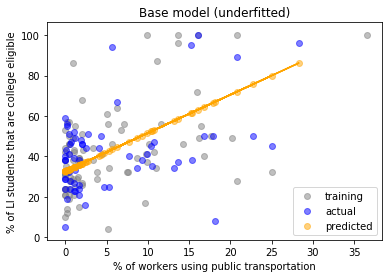

In [709]:
f, ax1 = plt.subplots()
ax1.scatter(X_train_base, y_train_base, alpha=0.5, color='gray', label='training')
ax1.scatter(X_test_base, y_test_base, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test_base, y_pred_base, alpha=0.5, color='orange', label='predicted')
ax1.plot(X_test_base, y_pred_base, color='orange')
ax1.legend();

ax1.set_title('Base model (underfitted)')
ax1.set_xlabel('% of workers using public transportation');
ax1.set_ylabel('% of LI students that are college eligible');

In [710]:
# Error metrics
print('Mean absolute error: ', metrics.mean_absolute_error(y_test_base, y_pred_base))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error: ', np.sqrt(metrics.mean_squared_error(y_test_base, y_pred_base)))

Mean absolute error:  14.79626311355774
Root mean squared error:  18.437304888626908


### Feature transformation

- Use polynomial terms to get a better fit

In [711]:
from sklearn.preprocessing import PolynomialFeatures

In [712]:
def return_model_fitted_wpoly(df, X_feature_list, y_feature, test_size_value, degree):
    
    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = df[X_feature_list + [y_feature]].notnull().sum(axis=1)==(len(X_feature_list) + 1)
    df_clean = df.copy().loc[k_rows2keep, X_feature_list + [y_feature]]
    
    if len(X_feature_list)==1:
        X = df_clean[X_feature_list[0]].copy().values.reshape(-1,1)
        y = df_clean[y_feature].copy().values.reshape(-1,1)
    else:
        X = df_clean[X_feature_list].copy().values
        y = df_clean[y_feature].copy().values
    
    # Adding polynomial features
    polynomial_features= PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size_value)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    return reg, X_train, X_test, y_train, y_test

#### Degree 2

In [720]:
X_feature_list = (['%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)'])
y = 'graduation_rates_UCCSU_eligibility_LIstudents'
test_size = 0.4
degree = 2

(reg_1f_deg2, X_train_deg2, X_test_deg2, y_train_deg2, y_test_deg2) = return_model_fitted_wpoly(df_state_info_gs_census, X_feature_list, y, test_size, degree)

In [721]:
print('intercept: ', reg_1f_deg2.intercept_)
print('coefficients: ', reg_1f_deg2.coef_)

intercept:  [32.39354543]
coefficients:  [[ 0.          3.10448551 -0.09182334]]


In [745]:
y_pred_deg2 = reg_1f_deg2.predict(X_test_deg2)

In [746]:
# Note that the first column is a vector of 1's for Beta0 coefficient
# columns are 1's, x, x**2
X_train_deg2[0:5, 0:3]

array([[  1.  ,  16.8 , 282.24],
       [  1.  ,  11.1 , 123.21],
       [  1.  ,   3.4 ,  11.56],
       [  1.  ,   0.  ,   0.  ],
       [  1.  ,   0.  ,   0.  ]])

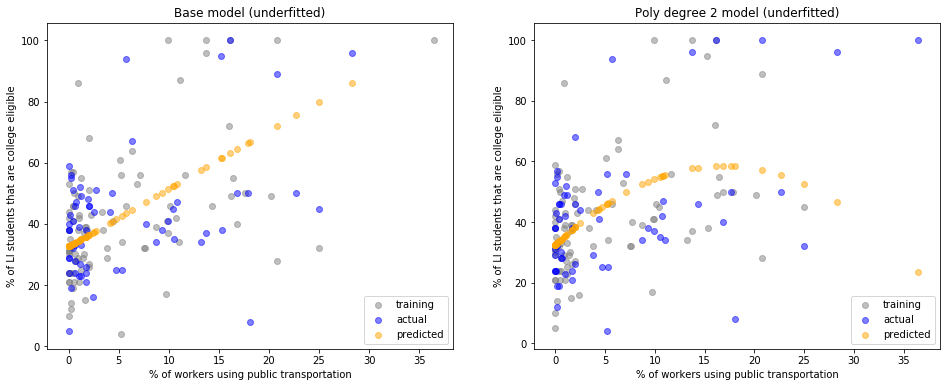

In [759]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.scatter(X_train_base, y_train_base, alpha=0.5, color='gray', label='training')
ax1.scatter(X_test_base, y_test_base, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test_base, y_pred_base, alpha=0.5, color='orange', label='predicted')
#ax1.plot(X_test_base, y_pred_base, color='orange')
ax1.legend();
ax1.set_title('Base model (underfitted)')
ax1.set_xlabel('% of workers using public transportation');
ax1.set_ylabel('% of LI students that are college eligible');

ax2.scatter(X_train_deg2[:, 1], y_train_deg2, alpha=0.5, color='gray', label='training')
ax2.scatter(X_test_deg2[:, 1], y_test_deg2, color='blue', alpha=0.5, label='actual')
ax2.scatter(X_test_deg2[:, 1], y_pred_deg2, alpha=0.5, color='orange', label='predicted')
#ax1.plot(X_test_deg2[:, 1], y_pred_deg2, color='orange')
ax2.legend();

ax2.set_title('Poly degree 2 model (underfitted)')
ax2.set_xlabel('% of workers using public transportation');
ax2.set_ylabel('% of LI students that are college eligible');

In [755]:
# Error metrics
print('Mean absolute error - base model: ', metrics.mean_absolute_error(y_test_base, y_pred_base))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error - base model: ', np.sqrt(metrics.mean_squared_error(y_test_base, y_pred_base)))

# Error metrics
print('Mean absolute error - polydeg2 model: ', metrics.mean_absolute_error(y_test_deg2, y_pred_deg2))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error - polydeg2 model: ', np.sqrt(metrics.mean_squared_error(y_test_deg2, y_pred_deg2)))

Mean absolute error - base model:  14.79626311355774
Root mean squared error - base model:  18.437304888626908
Mean absolute error - polydeg2 model:  16.515197804631093
Root mean squared error - polydeg2 model:  21.910367008288315


#### Degree 3

In [756]:
X_feature_list = (['%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)'])
y = 'graduation_rates_UCCSU_eligibility_LIstudents'
test_size = 0.4
degree = 3

(reg_1f_deg3, X_train_deg3, X_test_deg3, y_train_deg3, y_test_deg3) = return_model_fitted_wpoly(df_state_info_gs_census, X_feature_list, y, test_size, degree)

In [757]:
print('intercept: ', reg_1f_deg3.intercept_)
print('coefficients: ', reg_1f_deg3.coef_)

intercept:  [33.11306286]
coefficients:  [[ 0.00000000e+00  2.15134793e+00 -8.33177254e-02  1.69626711e-03]]


In [758]:
y_pred_deg3 = reg_1f_deg3.predict(X_test_deg3)

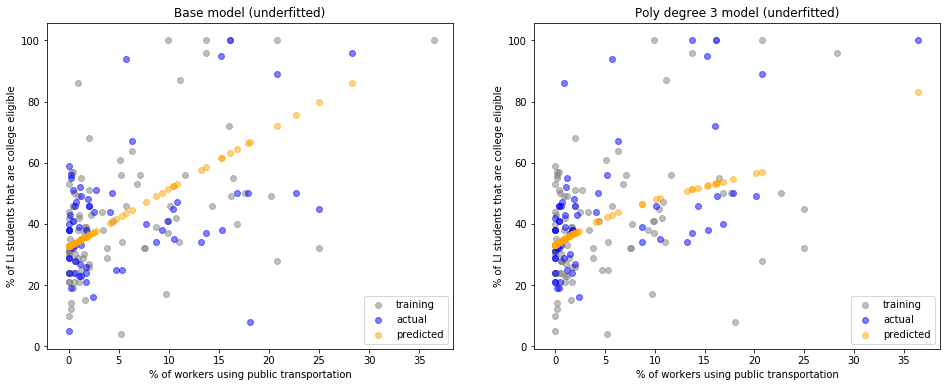

In [760]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.scatter(X_train_base, y_train_base, alpha=0.5, color='gray', label='training')
ax1.scatter(X_test_base, y_test_base, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test_base, y_pred_base, alpha=0.5, color='orange', label='predicted')
#ax1.plot(X_test_base, y_pred_base, color='orange')
ax1.legend();
ax1.set_title('Base model (underfitted)')
ax1.set_xlabel('% of workers using public transportation');
ax1.set_ylabel('% of LI students that are college eligible');

ax2.scatter(X_train_deg3[:, 1], y_train_deg3, alpha=0.5, color='gray', label='training')
ax2.scatter(X_test_deg3[:, 1], y_test_deg3, color='blue', alpha=0.5, label='actual')
ax2.scatter(X_test_deg3[:, 1], y_pred_deg3, alpha=0.5, color='orange', label='predicted')
#ax1.plot(X_test_deg3[:, 1], y_pred_deg3, color='orange')
ax2.legend();

ax2.set_title('Poly degree 3 model (underfitted)')
ax2.set_xlabel('% of workers using public transportation');
ax2.set_ylabel('% of LI students that are college eligible');

In [761]:
# Error metrics
print('Mean absolute error - base model: ', metrics.mean_absolute_error(y_test_base, y_pred_base))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error - base model: ', np.sqrt(metrics.mean_squared_error(y_test_base, y_pred_base)))

# Error metrics
print('Mean absolute error - polydeg3 model: ', metrics.mean_absolute_error(y_test_deg3, y_pred_deg3))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error - polydeg3 model: ', np.sqrt(metrics.mean_squared_error(y_test_deg3, y_pred_deg3)))

Mean absolute error - base model:  14.79626311355774
Root mean squared error - base model:  18.437304888626908
Mean absolute error - polydeg3 model:  12.762672989900008
Root mean squared error - polydeg3 model:  17.597602104144897


#### Degree 5

In [763]:
X_feature_list = (['%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)'])
y = 'graduation_rates_UCCSU_eligibility_LIstudents'
test_size = 0.4
degree = 5

(reg_1f_deg5, X_train_deg5, X_test_deg5, y_train_deg5, y_test_deg5) = return_model_fitted_wpoly(df_state_info_gs_census, X_feature_list, y, test_size, degree)

In [764]:
print('intercept: ', reg_1f_deg5.intercept_)
print('coefficients: ', reg_1f_deg5.coef_)

intercept:  [36.71142586]
coefficients:  [[ 0.00000000e+00 -2.56078246e-01  1.45417940e-01  1.44960329e-02
  -1.49298400e-03  2.81514323e-05]]


In [765]:
y_pred_deg5 = reg_1f_deg5.predict(X_test_deg5)

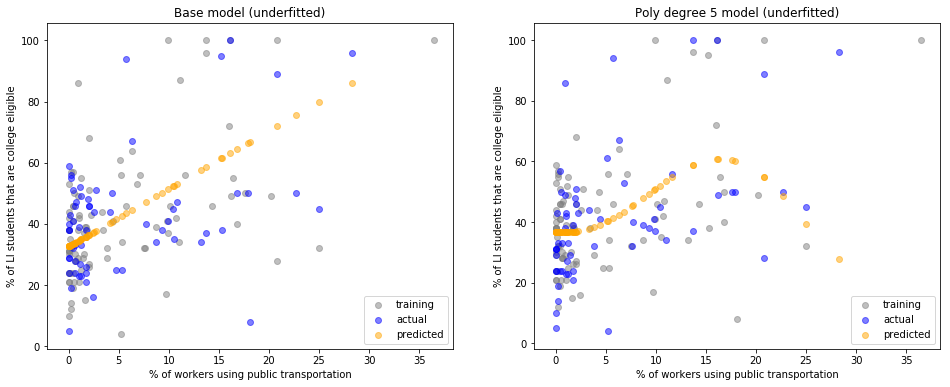

In [767]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.scatter(X_train_base, y_train_base, alpha=0.5, color='gray', label='training')
ax1.scatter(X_test_base, y_test_base, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test_base, y_pred_base, alpha=0.5, color='orange', label='predicted')
#ax1.plot(X_test_base, y_pred_base, color='orange')
ax1.legend();
ax1.set_title('Base model (underfitted)')
ax1.set_xlabel('% of workers using public transportation');
ax1.set_ylabel('% of LI students that are college eligible');

ax2.scatter(X_train_deg5[:, 1], y_train_deg5, alpha=0.5, color='gray', label='training')
ax2.scatter(X_test_deg5[:, 1], y_test_deg5, color='blue', alpha=0.5, label='actual')
ax2.scatter(X_test_deg5[:, 1], y_pred_deg5, alpha=0.5, color='orange', label='predicted')
#ax1.plot(X_test_deg5[:, 1], y_pred_deg5, color='orange')
ax2.legend();

ax2.set_title('Poly degree 5 model (underfitted)')
ax2.set_xlabel('% of workers using public transportation');
ax2.set_ylabel('% of LI students that are college eligible');

In [769]:
# Error metrics
print('Mean absolute error - base model: ', metrics.mean_absolute_error(y_test_base, y_pred_base))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error - base model: ', np.sqrt(metrics.mean_squared_error(y_test_base, y_pred_base)))

# Error metrics
print('Mean absolute error - polydeg3 model: ', metrics.mean_absolute_error(y_test_deg3, y_pred_deg3))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error - polydeg3 model: ', np.sqrt(metrics.mean_squared_error(y_test_deg3, y_pred_deg3)))

# Error metrics
print('Mean absolute error - polydeg5 model: ', metrics.mean_absolute_error(y_test_deg5, y_pred_deg5))
#print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root mean squared error - polydeg5 model: ', np.sqrt(metrics.mean_squared_error(y_test_deg5, y_pred_deg5)))

Mean absolute error - base model:  14.79626311355774
Root mean squared error - base model:  18.437304888626908
Mean absolute error - polydeg3 model:  12.762672989900008
Root mean squared error - polydeg3 model:  17.597602104144897
Mean absolute error - polydeg5 model:  15.088019646133272
Root mean squared error - polydeg5 model:  20.132910142624773


### Rescaling with RobustScaler()

I chose this since it is less sensitive to outliers. The scaling is based on percentiles, with 0.25 and 0.75 as the default values.

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(X_train[:, 0], X_train[:, 1])
ax1.set_title('unscaled')
ax1.set_xlabel('pct families below poverty line')
ax1.set_ylabel('test score rating, LI students')

# Robust scaler - uses 0.25 and 0.75 as default quantile 
# less sensitive to outliers, but not sure if it's necessary
X_scale = RobustScaler().fit_transform(X_train)
ax2.scatter(X_scale[:, 0], X_scale[:, 1])
ax2.set_xlabel('pct families below poverty line')
ax2.set_ylabel('test score rating, LI students')

In [ ]:

# Robust scaler - uses 0.25 and 0.75 as default quantile 
# less sensitive to outliers, but not sure if it's necessary
X_scale = RobustScaler().fit_transform(X_train)
ax2.scatter(X_scale[:, 0], X_scale[:, 1])
ax2.set_xlabel('pct families below poverty line')
ax2.set_ylabel('test score rating, LI students')

#### Determine independence of features with Pearson correlation check

Find features that actually correlate but do after getting GS info. Get Pearson's across all.

Might have to rescale first?


In [ ]:
# Limit to features that are based on percentage so that I know they're on a similar scale
df_school_demographics_pct = df_school_demographics.loc[:, df_school_demographics.columns.str.contains('%')]
# Get Pearson's with at least 3/4 of observations required per pair of columns to have valid result
df_pct_corr = df_school_demographics_pct.corr(method='pearson', min_periods=round(0.75*len(df_school_demographics_pct.index)))


# Find a feature that negatively correlates the most with this one

df_pct_corr.loc['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people', :].sort_values()

In [ ]:
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(64,24))
f, (ax1) = plt.subplots(1, 1, figsize=(64,24))
ax1.imshow(df_pct_corr);
ax1.set_yticks(np.arange(0, len(df_school_demographics_sd_pct.columns), 1));
ax1.set_yticklabels([str(i) + ' ' + feature for (i, feature) in enumerate(df_school_demographics_pct.columns)]);
ax1.set_xticks(np.arange(0, len(df_school_demographics_sd_pct.columns), 1));
ax1.set_xticks(np.arange(0, len(df_school_demographics_pct.columns), 1));

# plt.savefig('repo/correlations.png')

#### START - LAU test

In [1353]:
# Merge great schools and school info on zip code
df_district_info_gs_LA = pd.merge(df_school_info_LA_schools_LU, df_district_tp_LA,
                               how='inner', left_on='School', right_index=True)

In [1358]:
# Merge great schools, school info and demographic info on zip code
df_district_info_gs_census_LA = pd.merge(df_district_info_gs_LA, df_census,
                                      how='inner', left_on='zip_code', right_index=True)

In [1359]:
df_district_info_gs_census_LA

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
4863,19647330100677,0622710,10829,Active,Los Angeles,Los Angeles Unified,High Tech LA,17111 Victory Boulevard,17111 Victory Blvd.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
5077,19647330120360,0622710,12525,Active,Los Angeles,Los Angeles Unified,Daniel Pearl Journalism & Communications Magnet,6649 Balboa Boulevard,6649 Balboa Blvd.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
5377,19647331931047,0622710,02857,Active,Los Angeles,Los Angeles Unified,Birmingham Community Charter High,17000 Haynes Street,17000 Haynes St.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
4865,19647330100750,0622710,11365,Active,Los Angeles,Los Angeles Unified,Wallis Annenberg High,4000 South Main Street,4000 South Main St.,Los Angeles,...,37.7,40.9,54.0,53.8,51.6,35.5,35.9,31.1,38.9,49.8
4960,19647330111492,0622710,11632,Active,Los Angeles,Los Angeles Unified,Alliance Patti And Peter Neuwirth Leadership A...,4610 South Main Street,4610 South Main St.,Los Angeles,...,37.7,40.9,54.0,53.8,51.6,35.5,35.9,31.1,38.9,49.8
5506,19647331935519,0622710,03163,Active,Los Angeles,Los Angeles Unified,Manual Arts Senior High,4131 South Vermont Avenue,4131 South Vermont Ave.,Los Angeles,...,37.7,40.9,54.0,53.8,51.6,35.5,35.9,31.1,38.9,49.8
4868,19647330100800,0622710,11337,Active,Los Angeles,Los Angeles Unified,Central City Value,221 North Westmoreland Avenue,221 North Westmoreland Ave.,Los Angeles,...,20.0,23.5,35.9,35.7,34.1,20.3,20.6,17.8,21.5,29.0
5230,19647330127910,0622710,13537,Active,Los Angeles,Los Angeles Unified,Camino Nuevo High #2,3500 West Temple Street,3500 West Temple St.,Los Angeles,...,20.0,23.5,35.9,35.7,34.1,20.3,20.6,17.8,21.5,29.0
4870,19647330101196,0622710,11358,Active,Los Angeles,Los Angeles Unified,ICEF View Park Preparatory Accelerated High,5701 South Crenshaw Boulevard,5701 South Crenshaw Blvd.,Los Angeles,...,14.4,21.7,30.4,29.9,30.8,19.4,21.1,12.0,18.0,33.9
5175,19647330124891,0622710,12848,Active,Los Angeles,Los Angeles Unified,Alliance Renee and Meyer Luskin Academy High,2941 West 70th Street,2941 West 70th St.,Los Angeles,...,14.4,21.7,30.4,29.9,30.8,19.4,21.1,12.0,18.0,33.9


In [1443]:
df4model = df_district_info_gs_census_LA[~df_district_info_gs_census_LA['gsRating'].isna()]


In [1444]:
df4model.head()

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
4863,19647330100677,0622710,10829,Active,Los Angeles,Los Angeles Unified,High Tech LA,17111 Victory Boulevard,17111 Victory Blvd.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
5077,19647330120360,0622710,12525,Active,Los Angeles,Los Angeles Unified,Daniel Pearl Journalism & Communications Magnet,6649 Balboa Boulevard,6649 Balboa Blvd.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
5377,19647331931047,0622710,02857,Active,Los Angeles,Los Angeles Unified,Birmingham Community Charter High,17000 Haynes Street,17000 Haynes St.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
4865,19647330100750,0622710,11365,Active,Los Angeles,Los Angeles Unified,Wallis Annenberg High,4000 South Main Street,4000 South Main St.,Los Angeles,...,37.7,40.9,54.0,53.8,51.6,35.5,35.9,31.1,38.9,49.8
4960,19647330111492,0622710,11632,Active,Los Angeles,Los Angeles Unified,Alliance Patti And Peter Neuwirth Leadership A...,4610 South Main Street,4610 South Main St.,Los Angeles,...,37.7,40.9,54.0,53.8,51.6,35.5,35.9,31.1,38.9,49.8


In [1445]:
# Count the number of missing values in each row

# n_null_values = list()
# k_bool_vector_list = list()
# for index in df4model.index:
#     k_bool_vector = df4model.loc[index, :].isna()
#     k_bool_vector_list.append(k_bool_vector)
#     print('--------------', k_bool_vector.sum(), '--------------')
#     print(df4model.loc[index, k_bool_vector])
#     n_null_values.append(k_bool_vector.sum())

# ------ by looking at the number of missing values, I'll set a cutoff of 5 or less to keep in the model df

rows2keep = pd.Series(n_null_values) < 5
df4model_filt = df4model.loc[rows2keep.tolist(), :]

In [1454]:
# Identify and change values to integer that were string

# for i_col in range(len(df4model_filt.columns)):
#     print(df4model_filt.columns[i_col], '---', df4model_filt.iloc[0, i_col], '---', type(df4model_filt.iloc[0, i_col]))

# df4model_filt['gsId'] = df4model_filt['gsId'].astype('int')
# df4model_filt['enrollment'] = df4model_filt['enrollment'].astype('int')
# df4model_filt['gsRating'] = df4model_filt['gsRating'].astype('int')
# df4model_filt['parentRating'] = df4model_filt['parentRating'].astype('int')
# df4model_filt['districtId'] = df4model_filt['districtId'].astype('int')

/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

ValueError: cannot convert float NaN to integer

In [1515]:
def str2int_except_none(df, colheader):
    value_int_list = list()
    for value in df.copy().loc[:, colheader]:
        try:
            value_int_list.append(int(value))
        except:
            value_int_list.append(np.nan)
    
    return value_int_list

In [1518]:
df4model_filt.loc[:, 'gsId'] = str2int_except_none(df4model_filt, 'gsId')
df4model_filt.loc[:, 'enrollment'] = str2int_except_none(df4model_filt, 'enrollment')
df4model_filt.loc[:, 'gsRating'] = str2int_except_none(df4model_filt, 'gsRating')
df4model_filt.loc[:, 'parentRating'] = str2int_except_none(df4model_filt, 'parentRating')
df4model_filt.loc[:, 'districtId'] = str2int_except_none(df4model_filt, 'districtId')

/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


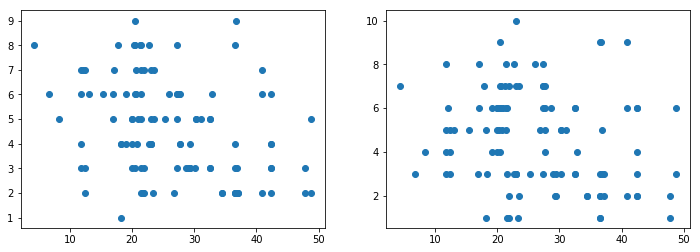

In [1361]:
# No real correlation

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df4model['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'],
            df4model['gsRating'])

ax2.scatter(df4model['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'],
            df4model['low_income'])

In [1365]:
#df4model.to_csv('repo/df4model.csv')

#### END - LAU test

In [1169]:
df_jack = df_district_info_gs_census[~df_district_info_gs_census['gsRating'].isna()]

In [1170]:
df_jack['gsRating'] = [int(i) for i in df_jack.loc[:, 'gsRating']]

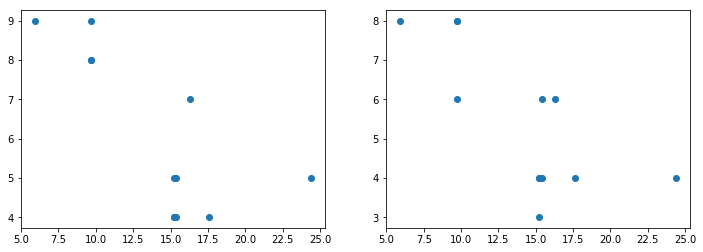

In [1171]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df_jack['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'],
            df_jack['gsRating'])

ax2.scatter(df_jack['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'],
            df_jack['low_income'])

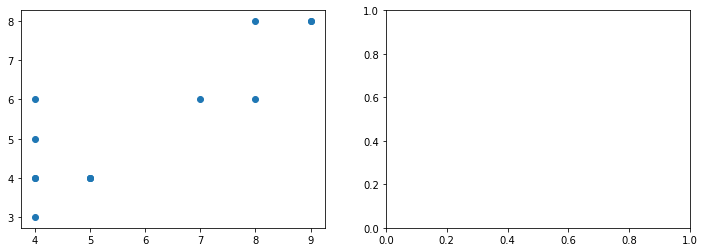

In [752]:
# Are schools that are good with low income ratings, generally good schools overall?
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df_jack['gsRating'],
            df_jack['low_income'])

### Make a fit with one variable

In [1366]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [754]:
X = df_jack['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'].copy().values.reshape(-1,1)
y = df_jack['low_income'].copy().values.reshape(-1,1)

In [755]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.4)

In [756]:
reg_model = LinearRegression()

In [757]:
reg_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [758]:
print('intercept: ', reg_model.intercept_)
print('coefficients: ', reg_model.coef_)

intercept:  [8.78168306]
coefficients:  [[-0.22354078]]


In [759]:
pred = reg_model.predict(X_test)
pred

array([[5.38386327],
       [4.84736541],
       [5.13796842],
       [3.32728814],
       [7.46279249],
       [6.61333754]])

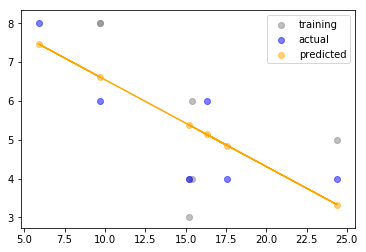

In [765]:
f, ax1 = plt.subplots()
ax1.scatter(X_train, y_train, alpha=0.5, color='gray', label='training')
ax1.scatter(X_test, y_test, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test, pred, alpha=0.5, color='orange', label='predicted')
ax1.plot(X_test, pred, color='orange')
ax1.legend();

In [766]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, pred))

mean absolute error:  0.819419529920427
mean squared error:  0.7489200406226537


### START - LAU test

In [1519]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [1520]:
df4model.head()

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
4863,19647330100677,0622710,10829,Active,Los Angeles,Los Angeles Unified,High Tech LA,17111 Victory Boulevard,17111 Victory Blvd.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
5077,19647330120360,0622710,12525,Active,Los Angeles,Los Angeles Unified,Daniel Pearl Journalism & Communications Magnet,6649 Balboa Boulevard,6649 Balboa Blvd.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
5377,19647331931047,0622710,02857,Active,Los Angeles,Los Angeles Unified,Birmingham Community Charter High,17000 Haynes Street,17000 Haynes St.,Lake Balboa,...,18.2,20.5,25.4,25.0,27.2,18.8,18.9,18.7,18.0,31.2
4865,19647330100750,0622710,11365,Active,Los Angeles,Los Angeles Unified,Wallis Annenberg High,4000 South Main Street,4000 South Main St.,Los Angeles,...,37.7,40.9,54.0,53.8,51.6,35.5,35.9,31.1,38.9,49.8
4960,19647330111492,0622710,11632,Active,Los Angeles,Los Angeles Unified,Alliance Patti And Peter Neuwirth Leadership A...,4610 South Main Street,4610 South Main St.,Los Angeles,...,37.7,40.9,54.0,53.8,51.6,35.5,35.9,31.1,38.9,49.8


In [1521]:
X = df4model['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'].copy().values.reshape(-1,1)
#X = df4model['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'].copy().values
y = df4model['graduation_rates_UCCSU_eligibility_LIstudents'].copy().values.reshape(-1,1)

In [1522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [1523]:
reg = LinearRegression()

In [1524]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1526]:
# Get intercept and coefficients
print('coefficient: ', reg.coef_)
print('intercept: ', reg.intercept_)

coefficient:  [[0.09117443]]
intercept:  [65.19704781]


In [1527]:
pred = reg.predict(X_test)

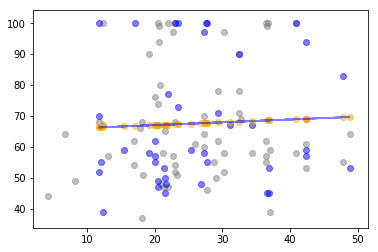

In [1532]:
# Visualize

f, ax1 = plt.subplots()
ax1.scatter(X_train, y_train, color='gray', alpha=0.5, label='train')
ax1.plot(X_test, pred, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test, y_test, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test, pred, color='orange', alpha=0.5, label='predicted')


In [ ]:
# Find errors of each point? - what to do if it was based on a training set?

In [1607]:
X_feature_list = ['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people']
y = 'graduation_rates_UCCSU_eligibility_LIstudents'
test_size = 0.4

(reg_1f, X_train, X_test, y_train, y_test) = return_model_fitted(df4model_filt, X_feature_list, y, test_size)

In [1608]:
y_pred = reg_1f.predict(X_test)

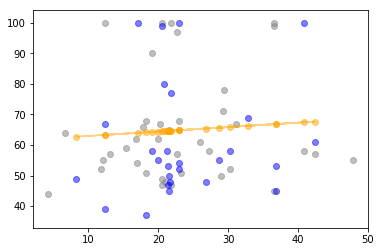

In [1609]:
f, ax1 = plt.subplots()
ax1.scatter(X_train, y_train, color='gray', alpha=0.5, label='train')
ax1.scatter(X_test, y_test, color='blue', alpha=0.5, label='test')
ax1.scatter(X_test, y_pred, color='orange', alpha=0.5, label='predicted');
ax1.plot(X_test, y_pred, color='orange', alpha=0.5, label='predicted');

In [1584]:
def return_error_metrics(y_test, y_pred):
    # Account for test sets that may not have a value
    k_bool2keep = ~pd.isnull(y_test)
    pct_valid_y_test = 100*(k_bool2keep.sum() / len(y_test))
    mean_abs_error = metrics.mean_absolute_error(y_test[k_bool2keep], y_pred[k_bool2keep])
    mean_squared_error = metrics.mean_squared_error(y_test[k_bool2keep], y_pred[k_bool2keep])

    return pct_valid_y_test, mean_abs_error, mean_squared_error

In [1586]:
return_error_metrics(y_test, y_pred)

(100.0, 16.21342651538615, 360.48794042375124)

In [ ]:
# model

In [ ]:
# y_test, pred

### END - LAU test

#### Two variables

In [767]:
X = df_jack[['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people',
             '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone']].copy()
y = df_jack['low_income'].copy()

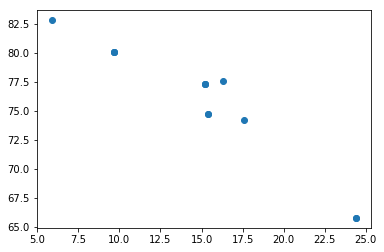

In [768]:
# Do variables correlate with each other - they do
f, ax1 = plt.subplots()
ax1.scatter(X.iloc[:,0], X.iloc[:,1])

In [646]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [647]:
reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [648]:
print('coefficients: ', reg.coef_)
print('intercept: ', reg.intercept_)

coefficients:  [-0.51951598 -0.31809233]
intercept:  37.66423266665447


In [649]:
y_pred = reg.predict(X_test)

In [650]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('square root of mean squared: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean absolute error:  0.7968321331043349
mean squared error:  0.8356701375354149
square root of mean squared:  0.9141499535280931


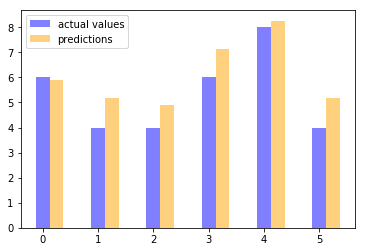

In [651]:
f, ax1 = plt.subplots()

ax1.bar(range(len(X_test)), y_test,
        width=0.25, label='actual values', color='blue', alpha=0.5)
ax1.bar([i+0.25 for i in range(len(X_test))], y_pred,
        width=0.25, label='predictions', color='orange', alpha=0.5)
ax1.legend()

#### Two variables with function

In [ ]:
# Visualize data with 3-coordinate axes to visualize the function

# https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

In [1657]:
X_feature_list = (['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people',
                 'test_score_rating_LIstudents'])
y = 'graduation_rates_UCCSU_eligibility_LIstudents'
test_size = 0.4

(reg_2f, X_train, X_test, y_train, y_test) = return_model_fitted(df4model_filt, X_feature_list, y, test_size)

In [1658]:
y_pred = reg_2f.predict(X_test)

In [1659]:
print('intercept; ', reg_2f.intercept_)
print('coefficients: ', reg_2f.coef_)

intercept;  46.052929921140866
coefficients:  [-0.21011582  5.1718634 ]


In [1660]:
X_train[0:5, 0:5]

array([[36.6, 9],
       [31.1, 5],
       [21.5, 1],
       [17.8, 7],
       [27.3, 3]], dtype=object)

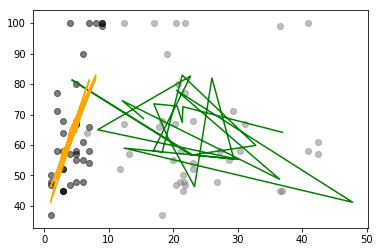

In [1661]:
# Plot features - dangers of not putting things on the same scale

f, ax1 = plt.subplots()
ax1.scatter(X_train[:, 0], y_train, color='gray', alpha=0.5, label='train, first variable')
ax1.scatter(X_train[:, 1], y_train, color='black', alpha=0.5, label='train, second variable')
ax1.plot(X_test[:, 0], y_pred, color='green', label='model, first variable')
ax1.plot(X_test[:, 1], y_pred, color='orange', label='model, second variable')
# ax1.plot(X_test[:, 0]*reg_2f.coef_[0] + X_test[:, 1]*reg_2f.coef_[1],
#          y_pred, color='red', label='model, linear combination variable');


In [1662]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))

mean absolute error:  17.096861753904964
mean squared error:  455.8917885233573


In [ ]:
# ------ DO SOMETHING LIKE THIS -------
f, ax1 = plt.subplots(1,1)
ax1.bar(range(len(df_compare)), df_compare['predictions'], label='predictions')
ax1.bar([i+0.5 for i in range(len(df_compare))], df_compare['actual'], label='actual')
ax1.legend();




#### Testing effect of different scalers

[excellent demo](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

Take home - it's important to look at distribution of all features that will go into the model and choose a scaler that's appropriate, especially if there are outliers. Since features are on a percentage or rating basis, I don't have to worry too much about outliers since they're bound by 0 and 100 or 0 and 10.


In [1621]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

/Users/lacar/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0,0.5,'test score rating, LI students')

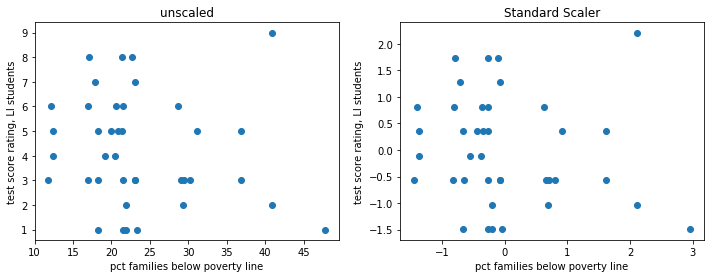

In [1639]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(X_train[:, 0], X_train[:, 1])
ax1.set_title('unscaled')
ax1.set_xlabel('pct families below poverty line')
ax1.set_ylabel('test score rating, LI students')

# Standard scaler - puts things with mean 0 and variance of 1
# (sensitive to outliers, but less of a concern here since our values are bound?)

X_scaled = StandardScaler().fit_transform(X_train)
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1])
ax2.set_title('Standard Scaler')
ax2.set_xlabel('pct families below poverty line')
ax2.set_ylabel('test score rating, LI students')

/Users/lacar/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0,0.5,'test score rating, LI students')

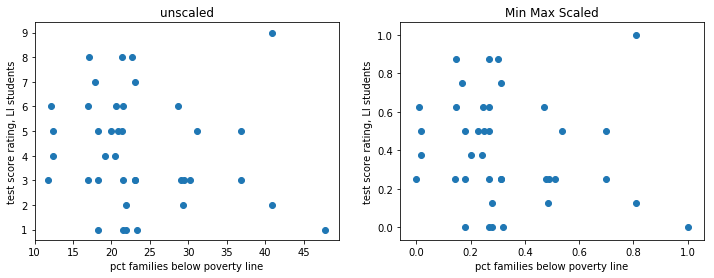

In [1640]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(X_train[:, 0], X_train[:, 1])
ax1.set_title('unscaled')
ax1.set_xlabel('pct families below poverty line')
ax1.set_ylabel('test score rating, LI students')

# Transform data with min-max scaling - puts everything between 0 and 1
# (sensitive to outliers, but less of a concern here since our values are bound?)

X_scale = MinMaxScaler().fit_transform(X_train)
ax2.scatter(X_scale[:, 0], X_scale[:, 1])
ax2.set_title('Min Max Scaled')
ax2.set_xlabel('pct families below poverty line')
ax2.set_ylabel('test score rating, LI students')

Text(0,0.5,'test score rating, LI students')

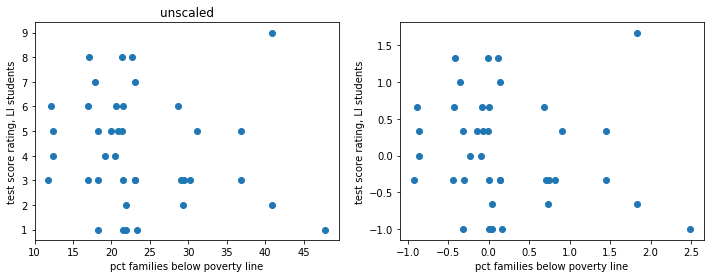

In [1642]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(X_train[:, 0], X_train[:, 1])
ax1.set_title('unscaled')
ax1.set_xlabel('pct families below poverty line')
ax1.set_ylabel('test score rating, LI students')

# Robust scaler - uses 0.25 and 0.75 as default quantile 
# less sensitive to outliers, but not sure if it's necessary
X_scale = RobustScaler().fit_transform(X_train)
ax2.scatter(X_scale[:, 0], X_scale[:, 1])
ax2.set_xlabel('pct families below poverty line')
ax2.set_ylabel('test score rating, LI students')

In [1681]:
def return_model_fitted_wscaling(df_clean, X_feature_list, y_feature, test_size_value):
    
    if len(X_feature_list)==1:
        X = df_clean[X_feature_list[0]].copy().values.reshape(-1,1)
        # Scale data with standard scaler
        X = StandardScaler().fit_transform(X)
        y = df_clean[y_feature].copy().values.reshape(-1,1)
    else:
        X = df_clean[X_feature_list].copy().values
        X = StandardScaler().fit_transform(X)
        y = df_clean[y_feature].copy().values
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_value)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    return reg, X_train, X_test, y_train, y_test
    

In [1682]:
X_feature_list = (['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people',
                 'test_score_rating_LIstudents'])
y = 'graduation_rates_UCCSU_eligibility_LIstudents'
test_size = 0.4

(reg_2f, X_train, X_test, y_train, y_test) = return_model_fitted_wscaling(df4model_filt, X_feature_list, y, test_size)

/Users/lacar/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [1683]:
print('intercept: ', reg_2f.intercept_)
print('coefficients: ', reg_2f.coef_)

intercept:  65.24897460210815
coefficients:  [4.90580308 7.20748711]


In [1684]:
y_pred = reg_2f.predict(X_test)

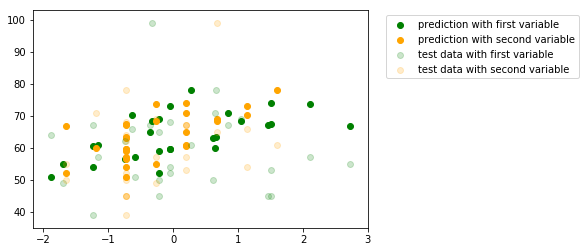

In [1685]:
f, ax1 = plt.subplots()

# ax1.scatter(X_train[:, 0], y_train, color='gray', alpha=0.1, label='training with first variable')
# ax1.scatter(X_train[:, 1], y_train, color='blue', alpha=0.1, label='training with second variable')

ax1.scatter(X_test[:, 0], y_pred, color='green', label='prediction with first variable')
ax1.scatter(X_test[:, 1], y_pred, color='orange', label='prediction with second variable')

ax1.scatter(X_test[:, 0], y_test, color='green', alpha=0.2, label='test data with first variable')
ax1.scatter(X_test[:, 1], y_test, color='orange', alpha=0.2, label='test data with second variable')

ax1.legend(bbox_to_anchor=(1.04, 1), loc='upper left', ncol=1);


In [1686]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))

mean absolute error:  11.223923158487766
mean squared error:  181.49813150241528


#### Three variables

In [661]:
X = df_jack[['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people',
             '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
            '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage']].copy()
y = df_jack['low_income'].copy()

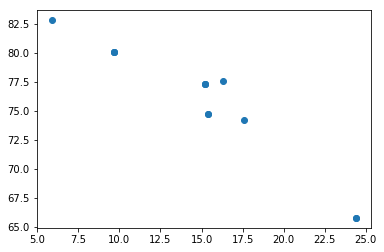

In [662]:
# Observe correlation
f, ax1 = plt.subplots()
ax1.scatter(X.iloc[:, 0], X.iloc[:, 1]);

In [663]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.4)

In [664]:
reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [665]:
print('coefficients: ', reg.coef_)
print('intercept: ', reg.intercept_)

coefficients:  [-0.87212981 -0.82019713  0.17717351]
intercept:  65.73499750978463


In [666]:
y_pred = reg.predict(X_test)

<BarContainer object of 6 artists>

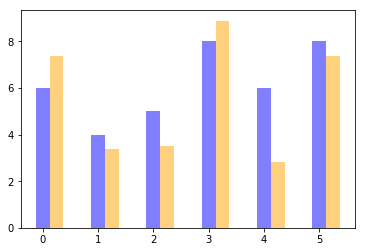

In [667]:
f, ax1 = plt.subplots()
ax1.bar(range(len(X_test)), y_test,
        width=0.25, color='blue', alpha=0.5)
ax1.bar([i+0.25 for i in range(len(X_test))], y_pred,
         width=0.25, color='orange', alpha=0.5)

In [668]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('square root of mean squared error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean absolute error:  1.3573370591871037
mean squared error:  2.5970929393757807
square root of mean squared error:  1.6115498563109305


In [ ]:
# Get UC/CSU eligibility

#### Using all pct features



In [669]:
X = df_jack.loc[:, df_jack.columns.str.startswith('%')].copy()
y = df_jack['low_income'].copy()

In [670]:
df_jack.loc[:, ['zip_code', 'School']]

,zip_code,School
12978,91913,Olympian High
12987,91913,Bonita Vista Senior High
12998,91913,Otay Ranch Senior High
12984,92154,Southwest Senior High
12997,92154,San Ysidro High
13005,92154,Montgomery Senior High
12988,91911,Castle Park Senior High
12990,91911,Chula Vista Senior High
12989,91915,Eastlake High
13000,91910,Hilltop Senior High


In [622]:
X

,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
12978,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,61.5,58.4,...,5.9,9.7,14.3,14.3,16.7,7.7,7.3,11.0,8.2,24.7
12987,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,61.5,58.4,...,5.9,9.7,14.3,14.3,16.7,7.7,7.3,11.0,8.2,24.7
12998,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,61.5,58.4,...,5.9,9.7,14.3,14.3,16.7,7.7,7.3,11.0,8.2,24.7
12984,60.5,59.1,51.7,7.4,1.4,39.5,12.5,57.8,57.4,51.0,...,9.1,15.2,21.4,20.9,21.3,12.9,13.2,11.4,13.3,34.2
12997,60.5,59.1,51.7,7.4,1.4,39.5,12.5,57.8,57.4,51.0,...,9.1,15.2,21.4,20.9,21.3,12.9,13.2,11.4,13.3,34.2
13005,60.5,59.1,51.7,7.4,1.4,39.5,12.5,57.8,57.4,51.0,...,9.1,15.2,21.4,20.9,21.3,12.9,13.2,11.4,13.3,34.2
12988,62.1,61.7,53.1,8.6,0.4,37.9,13.9,56.0,56.0,47.9,...,9.1,15.4,21.2,20.8,19.8,13.5,14.1,10.6,13.1,31.9
12990,62.1,61.7,53.1,8.6,0.4,37.9,13.9,56.0,56.0,47.9,...,9.1,15.4,21.2,20.8,19.8,13.5,14.1,10.6,13.1,31.9
12989,68.2,64.8,60.0,4.9,3.4,31.8,7.5,60.5,59.6,54.7,...,2.8,5.9,6.3,6.3,6.7,5.7,5.5,7.9,5.3,18.2
13000,62.2,61.3,53.9,7.4,0.9,37.8,12.0,56.5,55.9,49.6,...,12.0,16.3,24.3,24.0,22.1,13.9,14.0,13.2,14.0,28.6


## Look for other features that correlate with low income rating

In [ ]:
# Try to find number of low income students... could be statistical anomaly?